# Mass Spectrometry Model Training Pipeline

This notebook trains and evaluates classical and neural models for EI mass spectrum prediction. Given features $\mathbf{x}\in\mathbb{R}^d$ and sqrt-transformed spectra $\mathbf{y}\in\mathbb{R}_{\ge 0}^B$, models output $\hat{\mathbf{y}}\ge 0$ across $B$ bins. Metrics mirror the exploration notebooks for apples-to-apples comparison.

## Models Implemented
- Random Forest (multi-output)
- K-Nearest Neighbors (optimized)
- ModularNet (attention fusion)
- HierarchicalPredictionNet (presence → intensity)
- SparseGatedNet (sparsity-aware)
- RegionalExpertNet (m/z experts)
- K=4 ensemble (reference)

## Training/evaluation flow
```mermaid
flowchart LR
  A["Featurized x ∈ R^d"] --> S["StandardScaler (X)"]
  D["Targets y = √(ỹ)"] --> T
  S --> M{"Model"}
  T["Split: train/val/test"] --> M
  M --> Yhat["ŷ ≥ 0"]
  Yhat --> E["Metrics: cosine/MSE/MAE/F1"]
  Yhat --> R["Regional m/z"]
  E --> CKPT["Save best checkpoints"]
```

## Notes
- Data transform: $\mathbf{y}=\sqrt{\tilde{\mathbf{y}}}$. Predictions are clipped to non-negative.
- Primary score: cosine similarity on the $\sqrt{\cdot}$ scale.
- Visuals: standard 2×2 diagnostics, random spectrum grids, and training dashboards for neural models.

## 1. Environment Setup

- Imports scientific Python, scikit-learn, and PyTorch
- Selects device automatically (MPS → CUDA → CPU)
- Seeds NumPy/PyTorch/Random for reproducibility
- Configures a colorblind-friendly palette and plot defaults

Mermaid/MathJax are used in markdown only; no code changes required.

In [1]:
# Standard library imports
import os
import json
import pickle
import math
import warnings
import logging
import io
import random
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
from typing import Dict, Any, Tuple, List, Optional, Union

# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm import tqdm
from scipy.spatial.distance import cosine
from scipy.optimize import minimize
from scipy.ndimage import uniform_filter1d

# Machine learning imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    median_absolute_error, explained_variance_score,
    precision_recall_fscore_support, confusion_matrix
)

# Deep learning imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Chemistry imports (optional)
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    from rdkit.Chem.Draw import rdMolDraw2D
    RDKIT_AVAILABLE = True
    print("RDKit available for molecular structure visualization")
except ImportError:
    RDKIT_AVAILABLE = False
    print("Warning: RDKit not available. Molecular structure features will be limited.")

# Configure warnings and logging
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Device selection for PyTorch
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# Colorblind-friendly Okabe-Ito palette
PALETTE = {
    "blue": "#0072B2",
    "sky": "#56B4E9",
    "orange": "#E69F00",
    "vermillion": "#D55E00",
    "yellow": "#F0E442",
    "green": "#009E73",
    "purple": "#CC79A7",
    "black": "#000000",
    "grey": "#999999",
}

print("Environment setup complete")

RDKit available for molecular structure visualization
Using device: mps
Environment setup complete


## 2. Master Configuration

Central configuration for all models and training parameters.

- `paths`: results/models directories; HPJ input type; selected/full data
- `data`: `transform_sqrt=True` applies $y=\sqrt{\tilde y}$
- Model-specific blocks: RF, KNN, ModularNet, HierarchicalPredictionNet, SparseGatedNet, RegionalExpertNet
- `evaluation`: `mz_step`, `peak_threshold`, `eval_frequency`

```mermaid
flowchart LR
  C["Config"] --> RF["RF params"]
  C --> KNN["KNN params"]
  C --> MN["ModularNet params"]
  C --> HP["Hierarchical params"]
  C --> SG["SparseGated params"]
  C --> RE["Regional Expert params"]
  C --> EVAL["Evaluation settings"]
```

In [2]:
MASTER_CONFIG = {
    # Paths configuration
    'paths': {
        'results_dir': '../data/results',
        'models_dir': '../models',
        'input_type': 'hpj',
        'use_selected_data': False,
        'data_subdir': lambda use_sel: 'selected' if use_sel else 'full_featurised'
    },
    
    # Data settings
    'data': {
        'random_state': 42,
        'transform_sqrt': True,  # Apply sqrt transformation to targets
    },
    
    # Random Forest hyperparameters
    'rf': {
        'n_estimators': 199,
        'max_depth': 39,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'n_jobs': -1
    },
    
    # KNN hyperparameters
    'knn': {
        'n_neighbors': 5,
        'weights': 'distance',
        'algorithm': 'ball_tree',
        'metric': 'hamming',
        'leaf_size': 5,
        'n_jobs': -1
    },
    
    # ModularNet hyperparameters
    'modularnet': {
        'num_modules': 4,
        'module_dims': [256, 128],
        'fusion_method': 'attention',
        'batch_size': 64,
        'epochs': 100,
        'learning_rate': 1e-3,
        'weight_intensity': 1.0,
        'weight_cosine': 1.0,
        'weight_sparsity': 1e-4
    },
    
    # HierarchicalPredictionNet hyperparameters
    'hierarchical': {
        'presence_hidden': [512, 256],
        'intensity_hidden': [512, 256, 128],
        'presence_threshold': 0.01,
        'conditional_dropout': 0.2,
        'batch_size': 64,
        'epochs': 100,
        'learning_rate': 1e-3,
        'weight_intensity': 1.0,
        'weight_cosine': 1.0,
        'weight_presence': 0.5,
        'weight_sparsity': 1e-4
    },
    
    # SparseGatedNet hyperparameters
    'sparsegated': {
        'hidden_dims': [1024, 512, 256],
        'gate_hidden': 128,
        'sparsity_threshold': 0.01,
        'gate_temperature': 1.0,
        'batch_size': 64,
        'epochs': 100,
        'learning_rate': 1e-3,
        'weight_intensity': 1.0,
        'weight_cosine': 1.0,
        'weight_sparsity': 1e-3
    },
    
    # RegionalExpertNet hyperparameters
    'regional': {
        'expert_regions': [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500)],
        'expert_hidden': [512, 256],
        'router_hidden': 256,
        'overlap_bins': 10,
        'batch_size': 64,
        'epochs': 100,
        'learning_rate': 1e-3,
        'weight_intensity': 1.0,
        'weight_cosine': 1.0,
        'weight_sparsity': 1e-4
    },
    
    # Evaluation settings
    'evaluation': {
        'mz_step': 50,
        'max_mz': 1000,
        'peak_threshold': 0.01,
        'eval_frequency': 5
    }
}

# Create models directory
os.makedirs(MASTER_CONFIG['paths']['models_dir'], exist_ok=True)
print(f"Configuration loaded. Models will be saved to: {MASTER_CONFIG['paths']['models_dir']}")

Configuration loaded. Models will be saved to: ../models


## 3. Data Loading and Utility Functions

Data loading parses the same JSONL format as exploration notebooks; utilities compute cosine/WDP, peak metrics, and regional m/z analysis with uncertainties for ensembles.

```mermaid
flowchart LR
  JSONL["train/val/test JSONL"] --> Parse["Parse → (X, y)"]
  Parse --> Split["Scale X; √-transform y"]
  Split --> Loaders["PyTorch loaders (NN)"]
  Split --> Eval["Evaluation utilities"]
```

In [3]:
def get_data_paths(config):
    """Get data file paths based on configuration."""
    input_type_dir = os.path.join(config['paths']['results_dir'], config['paths']['input_type'])
    data_dir = os.path.join(input_type_dir, config['paths']['data_subdir'](config['paths']['use_selected_data']))
    
    return {
        'train': os.path.join(data_dir, 'train_data.jsonl'),
        'val': os.path.join(data_dir, 'val_data.jsonl'),
        'test': os.path.join(data_dir, 'test_data.jsonl')
    }

def load_jsonl_data(filepath):
    """Load data from JSONL file."""
    smiles_list, features, targets = [], [], []
    
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return smiles_list, np.array(features), np.array(targets)
    
    # Count lines for progress bar
    with open(filepath, 'r') as f:
        total_lines = sum(1 for _ in f)
    
    with open(filepath, 'r') as f:
        for line in tqdm(f, desc=f"Loading {os.path.basename(filepath)}", 
                       total=total_lines, unit="spectra"):
            try:
                record = json.loads(line)
                smiles = record.get("smiles")
                feat = record.get("features")
                targ = record.get("target")
                
                if smiles and feat is not None and targ is not None:
                    smiles_list.append(smiles)
                    features.append(feat)
                    targets.append(targ)
            except (json.JSONDecodeError, KeyError) as e:
                continue
    
    print(f"Loaded {len(smiles_list)} samples from {os.path.basename(filepath)}")
    return smiles_list, np.array(features), np.array(targets)

def load_all_data(config):
    """Load all datasets."""
    print("Loading datasets...")
    
    paths = get_data_paths(config)
    datasets = {}
    
    # Load datasets in parallel
    with ThreadPoolExecutor(max_workers=3) as executor:
        future_to_dataset = {
            executor.submit(load_jsonl_data, path): name 
            for name, path in paths.items()
        }
        
        for future in concurrent.futures.as_completed(future_to_dataset):
            dataset_name = future_to_dataset[future]
            try:
                datasets[dataset_name] = future.result()
            except Exception as e:
                print(f"Error loading {dataset_name} dataset: {e}")
                datasets[dataset_name] = ([], np.array([]), np.array([]))
    
    # Print dataset statistics
    for name, (smiles, X, y) in datasets.items():
        print(f"{name.capitalize()} data: {len(X)} samples, X shape: {X.shape}, y shape: {y.shape}")
    
    return datasets

def cosine_similarity_matrix(y_true, y_pred):
    """Calculate cosine similarity between true and predicted spectra."""
    similarities = []
    for i in range(len(y_true)):
        true_spec = y_true[i]
        pred_spec = y_pred[i]
        
        if np.sum(true_spec) == 0 or np.sum(pred_spec) == 0:
            cos_sim = 0 if np.sum(true_spec) != np.sum(pred_spec) else 1
        else:
            cos_sim = 1 - cosine(true_spec, pred_spec)
        
        similarities.append(cos_sim if not np.isnan(cos_sim) else 0)
    
    return np.mean(similarities), np.array(similarities)

def weighted_dot_product(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-8) -> float:
    """Calculate weighted dot product (WDP) score."""
    weights = y_true + eps
    numerator = np.sum(weights * y_true * y_pred)
    denominator = np.sum(weights * y_true * y_true) + eps
    return numerator / denominator

def get_model_predictions_with_uncertainty(model, X_scaled):
    """Return predictions and per-estimator predictions when available (e.g., RF)."""
    if hasattr(model, 'estimators_'):
        tree_predictions = np.array([est.predict(X_scaled) for est in model.estimators_])
        y_pred = np.mean(tree_predictions, axis=0)
        return y_pred, tree_predictions
    else:
        y_pred = model.predict(X_scaled)
        return y_pred, None

def cosine_similarity_by_mz_range(y_true, y_pred, config, tree_predictions=None):
    """Calculate cosine similarity for different m/z ranges with uncertainties."""
    spectrum_length = y_true.shape[1]
    step_size = config['evaluation']['mz_step']
    max_mz = min(config['evaluation']['max_mz'], spectrum_length)
    
    # Use mean across estimators for main curve if available
    y_mean_pred = np.mean(tree_predictions, axis=0) if tree_predictions is not None else y_pred
    
    mz_ranges = {}
    for start in range(0, max_mz, step_size):
        end = min(start + step_size, max_mz)
        range_key = f"{start}-{end}"
        y_true_range = y_true[:, start:end]
        y_pred_range = y_mean_pred[:, start:end]
        
        similarities = []
        non_zero_samples = 0
        true_peaks = 0
        pred_peaks = 0
        
        for i in range(len(y_true)):
            t = y_true_range[i]
            p = y_pred_range[i]
            true_sum = np.sum(t)
            pred_sum = np.sum(p)
            
            # Count peaks (non-zero values)
            true_peaks += np.sum(t > 0)
            pred_peaks += np.sum(p > 0)
            
            # Count samples with non-zero intensity in this range
            if true_sum > 0 or pred_sum > 0:
                non_zero_samples += 1
            
            if true_sum == 0 or pred_sum == 0:
                sim = 0 if true_sum != pred_sum else 1
            else:
                sim = 1 - cosine(t, p)
            similarities.append(sim)
        
        # Uncertainties
        stat_uncertainty = np.std(similarities) / np.sqrt(len(similarities)) if len(similarities) > 1 else 0.0
        mean_sim = np.mean(similarities)
        
        if tree_predictions is not None:
            tree_sims = []
            for b in range(tree_predictions.shape[0]):
                p_b = tree_predictions[b, :, start:end]
                sims_b = []
                for i in range(len(y_true)):
                    t = y_true_range[i]
                    p = p_b[i]
                    if np.sum(t) == 0 or np.sum(p) == 0:
                        s = 0 if np.sum(t) != np.sum(p) else 1
                    else:
                        s = 1 - cosine(t, p)
                    sims_b.append(s)
                tree_sims.append(np.mean(sims_b))
            model_uncertainty = np.std(tree_sims)
        else:
            model_uncertainty = 0.0
        
        mz_ranges[range_key] = {
            'mean_similarity': mean_sim,
            'stat_uncertainty': stat_uncertainty,
            'model_uncertainty': model_uncertainty,
            'non_zero_samples': non_zero_samples,
            'total_samples': len(y_true),
            'coverage': non_zero_samples / len(y_true) * 100,
            'true_peaks': int(true_peaks),
            'pred_peaks': int(pred_peaks),
            'avg_true_peaks_per_spectrum': true_peaks / len(y_true),
            'avg_pred_peaks_per_spectrum': pred_peaks / len(y_true)
        }
    
    return mz_ranges

def evaluate_model(y_true, y_pred, config, model_name="Model", tree_predictions=None):
    """Comprehensive model evaluation."""
    # Calculate standard metrics
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    median_ae = median_absolute_error(y_true, y_pred)
    max_err = np.max(np.abs(y_true - y_pred))
    explained_var = explained_variance_score(y_true, y_pred)
    
    # Calculate cosine similarity
    mean_cosine_sim, all_cosine_sims = cosine_similarity_matrix(y_true, y_pred)
    
    # Calculate cosine similarity by m/z range
    mz_range_sims = cosine_similarity_by_mz_range(y_true, y_pred, config, tree_predictions)
    
    # Print results
    print(f"\n{model_name} Performance:")
    print(f"  Cosine Similarity: {mean_cosine_sim:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  R2 Score: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  Median AE: {median_ae:.4f}")
    print(f"  Max Error: {max_err:.4f}")
    print(f"  Explained Variance: {explained_var:.4f}")
    
    return {
        'cosine': mean_cosine_sim,
        'y_pred': y_pred,
        'y_true': y_true,
        'individual_cos_sims': all_cosine_sims,
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'median_ae': median_ae,
        'max_err': max_err,
        'explained_var': explained_var,
        'mz_range_sims': mz_range_sims
    }

print("Utility functions loaded")

Utility functions loaded


## 4. Standard Visualization Functions

We reuse the standard 2×2 diagnostics, random spectrum grids, and (for neural nets) training dashboards.

```mermaid
flowchart TD
  Res["Results dict"] --> D1["Diagnostics 2×2"]
  Res --> D2["Random spectrum grid"]
  Hist["History (NN)"] --> D3["Training dashboard 2×2"]
```

In [4]:
def visualize_results(results, model_name="Model", show_uncertainties=True):
    """Create standard 2x2 evaluation visualization.
    
    1. Cosine Similarity Distribution (Top-Left)
    2. Performance by m/z Range (Top-Right)
    3. Intensity Correlation with Violin Density (Bottom-Left)
    4. Peak Count Comparison (Bottom-Right)
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # ---------- Top-Left: Cosine Similarity Distribution ----------
    ax = axes[0, 0]
    ax.hist(results['individual_cos_sims'], bins=30, range=(0, 1),
            alpha=0.85, color=PALETTE["blue"], edgecolor=PALETTE["black"], linewidth=0.5)
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Count')
    ax.set_title(f'Cosine Similarity Distribution - {model_name}')
    ax.axvline(results['cosine'], color=PALETTE["vermillion"], linestyle='--', linewidth=2,
               label=f"Mean: {results['cosine']:.4f}")
    ax.legend(frameon=False)
    ax.grid(alpha=0.3)
    
    # ---------- Top-Right: Performance by m/z with Uncertainties ----------
    ax = axes[0, 1]
    ranges = list(results['mz_range_sims'].keys())
    x_pos = np.arange(len(ranges))
    mean_sims = np.array([results['mz_range_sims'][r]['mean_similarity'] for r in ranges])
    stat_uncertainties = np.array([results['mz_range_sims'][r]['stat_uncertainty'] for r in ranges])
    model_uncertainties = np.array([results['mz_range_sims'][r]['model_uncertainty'] for r in ranges])
    
    if show_uncertainties:
        legend_handles = []
        # Statistical uncertainty (95% CI) — always if available
        if np.any(stat_uncertainties > 0):
            stat_ci = 1.96 * stat_uncertainties
            stat_lower = np.clip(mean_sims - stat_ci, 0, 1)
            stat_upper = np.clip(mean_sims + stat_ci, 0, 1)
            ax.fill_between(x_pos, stat_lower, stat_upper,
                            facecolor='none', edgecolor=PALETTE["yellow"],
                            hatch='////', linewidth=1.2, zorder=3)
            ax.plot(x_pos, stat_lower, linestyle='--', color=PALETTE["yellow"], linewidth=1.2, zorder=4)
            ax.plot(x_pos, stat_upper, linestyle='--', color=PALETTE["yellow"], linewidth=1.2, zorder=4)
            legend_handles.append(Patch(facecolor='none', edgecolor=PALETTE["yellow"], hatch='////',
                                        label='Statistical Uncertainty (95% CI)'))
        
        # Model uncertainty (±2σ) — only if available
        if np.any(model_uncertainties > 0):
            model_sigma = 2.0 * model_uncertainties
            model_lower = np.clip(mean_sims - model_sigma, 0, 1)
            model_upper = np.clip(mean_sims + model_sigma, 0, 1)
            ax.fill_between(x_pos, model_lower, model_upper,
                            facecolor=PALETTE["purple"], alpha=0.18,
                            edgecolor=PALETTE["purple"], linewidth=0.8, zorder=1)
            ax.plot(x_pos, model_lower, linestyle=':', color=PALETTE["purple"], linewidth=1.3, zorder=2)
            ax.plot(x_pos, model_upper, linestyle=':', color=PALETTE["purple"], linewidth=1.3, zorder=2)
            legend_handles.append(Patch(facecolor=PALETTE["purple"], alpha=0.18, edgecolor=PALETTE["purple"],
                                        label='Model Uncertainty (±2σ)'))
    
    ax.plot(x_pos, mean_sims, color=PALETTE["blue"], linewidth=2.5,
            label='Mean Cosine Similarity', marker='o', markersize=6, zorder=5)
    ax.set_xlabel('m/z Range')
    ax.set_ylabel('Cosine Similarity')
    ax.set_title(f'Performance by m/z Range - {model_name}')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(ranges, rotation=45)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(alpha=0.3)
    if show_uncertainties and len(legend_handles) > 0:
        ax.legend(handles=legend_handles, loc='lower left', fontsize=9, frameon=False)
    
    # ---------- Bottom-Left: True vs Predicted Intensity with Violin Density ----------
    ax = axes[1, 0]
    y_true_flat = np.ravel(results['y_true']).astype(float)
    y_pred_flat = np.ravel(results['y_pred']).astype(float)
    m = np.isfinite(y_true_flat) & np.isfinite(y_pred_flat)
    x = y_true_flat[m]
    y = y_pred_flat[m]
    
    # Rotate to (u,v) coordinates for violin visualization
    root2 = np.sqrt(2.0)
    u = (x + y) / root2
    v = (y - x) / root2
    
    # Bin along diagonal and compute quantiles
    n_bins = 60
    u_edges = np.linspace(u.min(), u.max(), n_bins + 1)
    u_centers = 0.5 * (u_edges[:-1] + u_edges[1:])
    widths_90 = np.full(n_bins, np.nan)
    widths_75 = np.full(n_bins, np.nan)
    widths_60 = np.full(n_bins, np.nan)
    min_count = 10
    
    for i in range(n_bins):
        mask = (u >= u_edges[i]) & (u < u_edges[i+1])
        if np.count_nonzero(mask) >= min_count:
            abs_v = np.abs(v[mask])
            widths_60[i] = np.percentile(abs_v, 60)
            widths_75[i] = np.percentile(abs_v, 75)
            widths_90[i] = np.percentile(abs_v, 90)
    
    # Interpolate and smooth
    def _interp_nan(a):
        xidx = np.arange(a.size)
        msk = ~np.isnan(a)
        if msk.sum() < 2:
            return np.nan_to_num(a, nan=0.0)
        return np.interp(xidx, xidx[msk], a[msk])
    
    def _smooth(a, k=5):
        if k <= 1: return a
        kernel = np.ones(k) / k
        return np.convolve(a, kernel, mode='same')
    
    widths_60 = _smooth(_interp_nan(widths_60), 5)
    widths_75 = _smooth(_interp_nan(widths_75), 5)
    widths_90 = _smooth(_interp_nan(widths_90), 5)
    
    def band_polygon(u_vals, w_vals):
        x_upper = (u_vals - w_vals) / root2
        y_upper = (u_vals + w_vals) / root2
        x_lower = (u_vals + w_vals) / root2
        y_lower = (u_vals - w_vals) / root2
        x_poly = np.r_[x_upper, x_lower[::-1]]
        y_poly = np.r_[y_upper, y_lower[::-1]]
        return x_poly, y_poly
    
    # Scatter points
    ax.scatter(x, y, s=4, marker='.', color=PALETTE["black"],
               edgecolors='none', alpha=1.0, zorder=0, rasterized=True)
    
    # Draw violin bands
    for w, a in [(widths_90, 0.25), (widths_75, 0.35), (widths_60, 0.5)]:
        xp, yp = band_polygon(u_centers, w)
        ax.fill(xp, yp, color=PALETTE["sky"], alpha=a, edgecolor='none', zorder=2)
    
    # Perfect prediction line - FIXED: Clip at 1.0 for normalized intensities
    max_val = 1.0  # Fixed to 1.0 for normalized intensities
    line_pp, = ax.plot([0, max_val], [0, max_val], color=PALETTE["vermillion"],
                       linestyle='--', linewidth=1.6, label='Perfect Prediction', zorder=4)
    
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel('True Intensity')
    ax.set_ylabel('Predicted Intensity')
    ax.set_title(f'Intensity Correlation - {model_name}')
    
    # Legend
    violin_handle = Patch(facecolor=PALETTE["sky"], alpha=0.35, edgecolor='none', label='Density (violin)')
    points_handle = Line2D([0], [0], linestyle='none', marker='.', markersize=6,
                           color=PALETTE["black"], label='All points')
    ax.legend(handles=[points_handle, violin_handle, line_pp], loc='lower right',
              frameon=True, facecolor='white', framealpha=0.85, edgecolor='none', handlelength=2.2)
    ax.grid(alpha=0.25)
    
    # Metrics annotation
    text = f"R² = {results['r2']:.4f}\nMAE = {results['mae']:.4f}"
    ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=11,
            va='top', bbox=dict(boxstyle='round', facecolor='wheat',
            alpha=0.6, edgecolor='none'), zorder=5)
    
    # ---------- Bottom-Right: Peak Count Comparison ----------
    ax = axes[1, 1]
    true_peaks = [results['mz_range_sims'][r]['avg_true_peaks_per_spectrum'] for r in ranges]
    pred_peaks = [results['mz_range_sims'][r]['avg_pred_peaks_per_spectrum'] for r in ranges]
    width = 0.35
    
    bars1 = ax.bar(x_pos - width/2, true_peaks, width, label='True',
                   color=PALETTE["green"], alpha=0.9, edgecolor=PALETTE["black"], linewidth=0.6)
    bars2 = ax.bar(x_pos + width/2, pred_peaks, width, label='Predicted',
                   color=PALETTE["blue"],  alpha=0.9, edgecolor=PALETTE["black"], linewidth=0.6)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            h = bar.get_height()
            if h > 0:
                ax.text(bar.get_x() + bar.get_width()/2., h, f'{h:.0f}',
                        ha='center', va='bottom', fontsize=12)
    
    ax.set_xlabel('m/z Range')
    ax.set_ylabel('Average Peaks per Spectrum')
    ax.set_title(f'Peak Count Comparison - {model_name}')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(ranges, rotation=45)
    ax.legend(frameon=False)
    ax.grid(alpha=0.3)
    
    plt.suptitle(f'Standard Diagnostic Suite: {model_name}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def create_spectrum_grid(results, test_smiles, n_examples=4, model_name="Model"):
    """Create 2x2 grid of random spectrum examples with molecular structures."""
    # Select random examples
    n_samples = len(results['y_true'])
    random_indices = np.random.choice(n_samples, min(n_examples, n_samples), replace=False)
    
    # Calculate metrics for selected examples
    selected_data = []
    for idx in random_indices:
        y_true = results['y_true'][idx]
        y_pred = results['y_pred'][idx]
        
        # Calculate cosine similarity
        if np.sum(y_true) == 0 and np.sum(y_pred) == 0:
            cosine_sim = 1.0
        elif np.sum(y_true) == 0 or np.sum(y_pred) == 0:
            cosine_sim = 0.0
        else:
            cosine_sim = 1 - cosine(y_true, y_pred)
        
        # Calculate WDP score
        wdp_score = weighted_dot_product(y_true, y_pred)
        
        # Get SMILES
        smiles = test_smiles[idx] if idx < len(test_smiles) else 'N/A'
        
        selected_data.append({
            'y_true': y_true,
            'y_pred': y_pred,
            'cosine_sim': cosine_sim,
            'wdp_score': wdp_score,
            'smiles': smiles,
            'index': idx
        })
    
    # Create figure
    fig = plt.figure(figsize=(20, 16))
    main_gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    print(f"\nSelected random examples:")
    
    for i, data in enumerate(selected_data[:4]):
        print(f"  {i+1}. Index {data['index']}: Cosine={data['cosine_sim']:.4f}, WDP={data['wdp_score']:.4f}")
        
        # Calculate position in 2x2 grid
        row = i // 2
        col = i % 2
        
        # Create sub-gridspec for this molecule
        sub_gs = gridspec.GridSpecFromSubplotSpec(2, 1, main_gs[row, col], 
                                                 height_ratios=[1, 1], hspace=0)
        
        ax1 = fig.add_subplot(sub_gs[0])  # Experimental
        ax2 = fig.add_subplot(sub_gs[1])  # Predicted
        
        # Process data (convert from sqrt scale if needed)
        y_true_scaled = data['y_true'] ** 2 if MASTER_CONFIG['data']['transform_sqrt'] else data['y_true']
        y_pred_scaled = data['y_pred'] ** 2 if MASTER_CONFIG['data']['transform_sqrt'] else data['y_pred']
        
        # Normalize to 0-100 scale
        if np.max(y_true_scaled) > 0:
            y_true_percent = (y_true_scaled / np.max(y_true_scaled)) * 100
        else:
            y_true_percent = y_true_scaled
            
        if np.max(y_pred_scaled) > 0:
            y_pred_percent = (y_pred_scaled / np.max(y_pred_scaled)) * 100
        else:
            y_pred_percent = y_pred_scaled
        
        # Find non-zero peaks for x-axis range
        mz_values = np.arange(len(data['y_true']))
        threshold = 0.1
        true_nonzero = y_true_percent > threshold
        pred_nonzero = y_pred_percent > threshold
        
        all_nonzero = true_nonzero | pred_nonzero
        if np.any(all_nonzero):
            nonzero_indices = np.where(all_nonzero)[0]
            min_mz = nonzero_indices[0]
            max_mz = nonzero_indices[-1]
            mz_range = max_mz - min_mz
            padding = max(10, int(0.05 * mz_range))
            x_min = max(0, min_mz - padding)
            x_max = min(len(data['y_true']), max_mz + padding)
        else:
            x_min = 0
            x_max = min(500, len(data['y_true']))
        
        # Top panel: Experimental spectrum
        if np.any(true_nonzero):
            markerline, stemlines, baseline = ax1.stem(
                mz_values[true_nonzero], 
                y_true_percent[true_nonzero],
                linefmt='b-', markerfmt=' ', basefmt=' '
            )
            stemlines.set_linewidth(1)
        
        ax1.set_ylabel('Intensity (%)', fontsize=10)
        ax1.text(0.5, 0.95, 'Experimental', transform=ax1.transAxes,
                 fontsize=11, ha='center', va='top')
        ax1.set_ylim(0, 110)
        ax1.grid(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.tick_params(bottom=False, labelbottom=False)
        
        # Bottom panel: Predicted spectrum (inverted)
        if np.any(pred_nonzero):
            markerline, stemlines, baseline = ax2.stem(
                mz_values[pred_nonzero], 
                -y_pred_percent[pred_nonzero],
                linefmt='r-', markerfmt=' ', basefmt=' '
            )
            stemlines.set_linewidth(1)
        
        ax2.set_ylim(-110, 0)
        ax2.set_ylabel('Intensity (%)', fontsize=10)
        ax2.set_xlabel('m/z (Da)', fontsize=10)
        ax2.text(0.5, 0.05, 'Predicted', transform=ax2.transAxes,
                 fontsize=11, ha='center', va='bottom')
        
        # Format y-axis to show positive values
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{abs(x):.0f}'))
        ax2.grid(False)
        ax2.spines['top'].set_visible(False)
        ax2.axhline(y=0, color='black', linewidth=1)
        
        # Set x-axis limits
        ax1.set_xlim(x_min, x_max)
        ax2.set_xlim(x_min, x_max)
        
        # Add molecular structure if available
        if data['smiles'] != "N/A" and RDKIT_AVAILABLE:
            try:
                mol = Chem.MolFromSmiles(data['smiles'])
                if mol:
                    mw = Descriptors.ExactMolWt(mol)
                    
                    # Create inset for molecular structure
                    axins = inset_axes(ax2, width="35%", height="50%", loc='lower right', 
                                       bbox_to_anchor=(0, 0.15, 1, 1), bbox_transform=ax2.transAxes)
                    
                    # Draw molecule
                    drawer = rdMolDraw2D.MolDraw2DCairo(300, 200)
                    drawer.DrawMolecule(mol)
                    drawer.FinishDrawing()
                    png = drawer.GetDrawingText()
                    bio = io.BytesIO(png)
                    img = plt.imread(bio, format='png')
                    axins.imshow(img)
                    axins.axis('off')
                    
                    # Add molecular weight
                    axins.text(0.5, -0.08, f'MW: {mw:.1f}', transform=axins.transAxes,
                              fontsize=9, ha='center', va='top', fontweight='bold')
            except:
                pass
        
        # Add title with scores
        title = f"Cosine: {data['cosine_sim']:.3f}, WDP: {data['wdp_score']:.3f}"
        ax1.set_title(title, fontsize=11, fontweight='bold')
    
    # Add overall title
    fig.suptitle(f'Random Spectrum Examples - {model_name}', fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_training_history(history, model_name="Neural Network"):
    """Create 2x2 deep learning training visualization.
    
    1. Loss Curves (Top-Left)
    2. Cosine Similarity (Top-Right)
    3. Peak Detection F1 (Bottom-Left)
    4. Learning Rate Schedule (Bottom-Right)
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # ---------- Top-Left: Loss Curves ----------
    ax = axes[0, 0]
    epochs = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs, history['train_loss'], label='Train', color=PALETTE["blue"], linewidth=2, alpha=0.8)
    
    if history.get('val_loss'):
        # Interpolate validation loss to match training epochs if evaluated less frequently
        val_epochs = np.array(range(MASTER_CONFIG['evaluation']['eval_frequency'], 
                                    len(history['train_loss']) + 1, 
                                    MASTER_CONFIG['evaluation']['eval_frequency']))
        val_epochs = val_epochs[:len(history['val_loss'])]
        ax.plot(val_epochs, history['val_loss'][:len(val_epochs)], 
               label='Validation', color=PALETTE["orange"], linewidth=2, alpha=0.8, marker='o', markersize=5)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'{model_name} - Training and Validation Loss')
    ax.legend(frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)
    
    # Highlight best epoch if validation loss exists
    if history.get('val_loss'):
        best_epoch_idx = np.argmin(history['val_loss'])
        best_epoch = val_epochs[best_epoch_idx] if best_epoch_idx < len(val_epochs) else val_epochs[-1]
        ax.axvline(x=best_epoch, color=PALETTE["vermillion"], linestyle='--', alpha=0.5, label='Best')
    
    # ---------- Top-Right: Cosine Similarity ----------
    ax = axes[0, 1]
    if history.get('val_cosine'):
        val_epochs = np.array(range(MASTER_CONFIG['evaluation']['eval_frequency'], 
                                    len(history['train_loss']) + 1, 
                                    MASTER_CONFIG['evaluation']['eval_frequency']))
        val_epochs = val_epochs[:len(history['val_cosine'])]
        ax.plot(val_epochs, history['val_cosine'][:len(val_epochs)], 
               color=PALETTE["green"], linewidth=2, marker='o', markersize=6, label='Val Cosine')
        
        # Add trend line
        if len(val_epochs) > 1:
            z = np.polyfit(val_epochs, history['val_cosine'][:len(val_epochs)], 1)
            p = np.poly1d(z)
            ax.plot(val_epochs, p(val_epochs), linestyle='--', color=PALETTE["grey"], alpha=0.5, label='Trend')
        
        # Highlight best
        best_cosine_idx = np.argmax(history['val_cosine'])
        best_cosine = history['val_cosine'][best_cosine_idx]
        best_epoch = val_epochs[min(best_cosine_idx, len(val_epochs)-1)]
        ax.scatter([best_epoch], [best_cosine], color=PALETTE["vermillion"], s=100, zorder=5, 
                  label=f'Best: {best_cosine:.4f}')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Cosine Similarity')
    ax.set_title(f'{model_name} - Validation Cosine Similarity')
    ax.legend(frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])
    
    # ---------- Bottom-Left: Peak Detection F1 ----------
    ax = axes[1, 0]
    if history.get('val_f1'):
        val_epochs = np.array(range(MASTER_CONFIG['evaluation']['eval_frequency'], 
                                    len(history['train_loss']) + 1, 
                                    MASTER_CONFIG['evaluation']['eval_frequency']))
        val_epochs = val_epochs[:len(history['val_f1'])]
        ax.plot(val_epochs, history['val_f1'][:len(val_epochs)], 
               color=PALETTE["purple"], linewidth=2, marker='s', markersize=6, label='Val F1')
        
        # Add smoothed curve
        if len(history['val_f1']) > 3:
            smoothed = uniform_filter1d(history['val_f1'][:len(val_epochs)], size=3, mode='nearest')
            ax.plot(val_epochs, smoothed, linestyle='--', color=PALETTE["grey"], 
                   alpha=0.5, label='Smoothed')
        
        # Highlight best
        best_f1_idx = np.argmax(history['val_f1'])
        best_f1 = history['val_f1'][best_f1_idx]
        best_epoch = val_epochs[min(best_f1_idx, len(val_epochs)-1)]
        ax.scatter([best_epoch], [best_f1], color=PALETTE["vermillion"], s=100, zorder=5,
                  label=f'Best: {best_f1:.4f}')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('F1 Score')
    ax.set_title(f'{model_name} - Peak Detection F1 Score')
    ax.legend(frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])
    
    # ---------- Bottom-Right: Learning Rate Schedule ----------
    ax = axes[1, 1]
    if history.get('lr'):
        epochs = range(1, len(history['lr']) + 1)
        ax.plot(epochs, history['lr'], color=PALETTE["vermillion"], linewidth=2, 
               marker='o', markersize=4)
        
        # Mark LR reductions
        lr_changes = []
        for i in range(1, len(history['lr'])):
            if history['lr'][i] < history['lr'][i-1]:
                lr_changes.append(i)
        
        for change_epoch in lr_changes:
            ax.axvline(x=change_epoch, color=PALETTE["grey"], linestyle=':', alpha=0.5)
            ax.annotate(f'LR↓', xy=(change_epoch, history['lr'][change_epoch]), 
                       xytext=(change_epoch, history['lr'][change_epoch]*2),
                       arrowprops=dict(arrowstyle='->', color=PALETTE["grey"], alpha=0.5),
                       fontsize=9, ha='center')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    ax.set_title(f'{model_name} - Learning Rate Schedule')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    
    # Add text annotation with final LR
    if history.get('lr'):
        final_lr = history['lr'][-1]
        ax.text(0.98, 0.98, f'Final LR: {final_lr:.2e}', transform=ax.transAxes,
               ha='right', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Overall title and layout
    plt.suptitle(f'Deep Learning Training Suite: {model_name}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

print("Visualization functions loaded")

Visualization functions loaded


## 5. Loss Functions for Deep Learning

Combined loss aggregates complementary criteria on the $\sqrt{\cdot}$ scale:

- MSE: $$\mathcal{L}_{\mathrm{mse}}=\tfrac{1}{B}\sum_b(\hat y_b - y_b)^2$$
- Cosine: $$\mathcal{L}_{\mathrm{cos}}=1-\tfrac{\langle y,\hat y\rangle}{\|y\|_2\,\|\hat y\|_2+\varepsilon}$$
- Sparsity: $$\mathcal{L}_{\mathrm{sp}}=\tfrac{1}{B}\sum_b|\hat y_b|$$
- Presence (Hierarchical): $$\mathcal{L}_{\mathrm{pres}}=\mathrm{BCE}(\sigma(z),\mathbb{1}[y>\tau])$$

Total: $$\mathcal{L}=w_1\mathcal{L}_{\mathrm{mse}}+w_2\mathcal{L}_{\mathrm{cos}}+w_3\mathcal{L}_{\mathrm{sp}}+w_4\mathcal{L}_{\mathrm{pres}}$$

In [5]:
def sparsity_loss(pred):
    """L1 regularization to encourage sparsity."""
    return pred.abs().mean()

def cosine_loss(pred, true, eps=1e-8):
    """Cosine distance loss."""
    num = (pred * true).sum(1)
    den = torch.norm(pred, 2, 1) * torch.norm(true, 2, 1) + eps
    return 1.0 - (num / den).mean()

def combined_loss(pred, true, config, presence_pred=None, presence_true=None):
    """Combined loss function for mass spectrometry."""
    losses = {}
    
    # Main losses
    losses['mse'] = F.mse_loss(pred, true)
    losses['cosine'] = cosine_loss(pred, true)
    losses['sparsity'] = sparsity_loss(pred)
    
    # Calculate total with weights
    total = (config.get('weight_intensity', 1.0) * losses['mse'] +
             config.get('weight_cosine', 1.0) * losses['cosine'] +
             config.get('weight_sparsity', 1e-4) * losses['sparsity'])
    
    # Add presence loss if provided (for HierarchicalPredictionNet)
    if presence_pred is not None and presence_true is not None:
        losses['presence'] = F.binary_cross_entropy_with_logits(presence_pred, presence_true)
        total += config.get('weight_presence', 0.5) * losses['presence']
    
    return total, losses

print("Loss functions loaded")

Loss functions loaded


## 6. Neural Network Training Framework

Loop essentials
- Optimizer: AdamW with weight decay
- Scheduler: ReduceLROnPlateau on validation cosine (mode max)
- Early stopping logic via best-val checkpointing
- Gradient clipping at 1.0

```mermaid
flowchart TD
  B["Batches (X,y)"] --> F["Forward pass"]
  F --> L["Loss (mse+cos+sp[+pres])"]
  L --> G["Backward + clip"]
  G --> U["Optimizer step"]
  U --> V["Eval every k epochs → cosine/F1"]
  V --> S["Scheduler step"]
  V --> C["Checkpoint best"]
```

In [6]:
def train_neural_network(model, train_loader, val_loader, config, model_name="Neural Network"):
    """Train a neural network with history tracking."""
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=1e-5
    )
    
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=5
    )
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_cosine': [],
        'val_f1': [],
        'lr': []
    }
    
    best_val_cosine = -1
    best_state = None
    
    print(f"\nTraining {model_name}...")
    print("=" * 60)
    
    for epoch in range(1, config['epochs'] + 1):
        # Training phase
        model.train()
        train_losses = []
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{config['epochs']}")
        
        for X_batch, y_batch in progress_bar:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            optimizer.zero_grad()
            
            # Handle different model types
            if hasattr(model, 'hierarchical_forward'):
                # HierarchicalPredictionNet
                predictions, presence_logits = model(X_batch, return_presence=True)
                presence_true = (y_batch > config.get('presence_threshold', 0.01)).float()
                loss, _ = combined_loss(predictions, y_batch, config, presence_logits, presence_true)
            else:
                predictions = model(X_batch)
                loss, _ = combined_loss(predictions, y_batch, config)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_losses.append(loss.item())
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        avg_train_loss = np.mean(train_losses)
        history['train_loss'].append(avg_train_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Validation phase
        if epoch % MASTER_CONFIG['evaluation']['eval_frequency'] == 0:
            model.eval()
            val_losses = []
            all_preds = []
            all_true = []
            
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch = X_batch.to(DEVICE)
                    y_batch = y_batch.to(DEVICE)
                    
                    if hasattr(model, 'hierarchical_forward'):
                        predictions = model(X_batch, return_presence=False)
                    else:
                        predictions = model(X_batch)
                    
                    loss, _ = combined_loss(predictions, y_batch, config)
                    val_losses.append(loss.item())
                    all_preds.append(predictions.cpu().numpy())
                    all_true.append(y_batch.cpu().numpy())
            
            y_pred = np.vstack(all_preds)
            y_true = np.vstack(all_true)
            
            # Calculate metrics
            mean_cosine, _ = cosine_similarity_matrix(y_true, y_pred)
            
            # Peak detection metrics
            y_true_binary = y_true > MASTER_CONFIG['evaluation']['peak_threshold']
            y_pred_binary = y_pred > MASTER_CONFIG['evaluation']['peak_threshold']
            
            tp = np.sum(y_true_binary & y_pred_binary)
            fp = np.sum(~y_true_binary & y_pred_binary)
            fn = np.sum(y_true_binary & ~y_pred_binary)
            
            precision = tp / (tp + fp + 1e-8)
            recall = tp / (tp + fn + 1e-8)
            f1 = 2 * precision * recall / (precision + recall + 1e-8)
            
            history['val_loss'].append(np.mean(val_losses))
            history['val_cosine'].append(mean_cosine)
            history['val_f1'].append(f1)
            
            scheduler.step(mean_cosine)
            
            print(f"  Val Loss: {np.mean(val_losses):.4f}, Cosine: {mean_cosine:.4f}, F1: {f1:.4f}")
            
            if mean_cosine > best_val_cosine:
                best_val_cosine = mean_cosine
                best_state = model.state_dict()
    
    # Load best model
    if best_state is not None:
        model.load_state_dict(best_state)
    
    print(f"\nTraining complete. Best validation cosine: {best_val_cosine:.4f}")
    
    return model, history

print("Training framework loaded")

Training framework loaded


## 7. Data Loading

Load and preprocess all datasets.

In [7]:
print("LOADING DATA")
print("=" * 60)

# Load all datasets
datasets = load_all_data(MASTER_CONFIG)
train_smiles, X_train, y_train = datasets['train']
val_smiles, X_val, y_val = datasets['val']
test_smiles, X_test, y_test = datasets['test']

if len(X_train) == 0:
    print("\nWarning: No real data found. Creating synthetic data for demonstration...")
    # Create synthetic data
    np.random.seed(MASTER_CONFIG['data']['random_state'])
    n_train, n_val, n_test = 500, 100, 100
    n_features, n_bins = 100, 500
    
    X_train = np.random.randn(n_train, n_features)
    X_val = np.random.randn(n_val, n_features)
    X_test = np.random.randn(n_test, n_features)
    
    # Create synthetic spectra with realistic sparsity
    y_train = np.zeros((n_train, n_bins))
    y_val = np.zeros((n_val, n_bins))
    y_test = np.zeros((n_test, n_bins))
    
    for i in range(n_train):
        n_peaks = np.random.randint(5, 20)
        peak_positions = np.random.choice(n_bins, n_peaks, replace=False)
        y_train[i, peak_positions] = np.random.exponential(0.5, n_peaks)
    
    for i in range(n_val):
        n_peaks = np.random.randint(5, 20)
        peak_positions = np.random.choice(n_bins, n_peaks, replace=False)
        y_val[i, peak_positions] = np.random.exponential(0.5, n_peaks)
    
    for i in range(n_test):
        n_peaks = np.random.randint(5, 20)
        peak_positions = np.random.choice(n_bins, n_peaks, replace=False)
        y_test[i, peak_positions] = np.random.exponential(0.5, n_peaks)
    
    test_smiles = ['N/A'] * n_test

print(f"\nData Summary:")
print(f"   Training samples: {len(X_train)}")
print(f"   Validation samples: {len(X_val)}")
print(f"   Test samples: {len(X_test)}")
print(f"   Feature dimensions: {X_train.shape[1]}")
print(f"   Spectrum dimensions: {y_train.shape[1]}")

# Apply transformation
if MASTER_CONFIG['data']['transform_sqrt']:
    y_train_transformed = np.sqrt(y_train)
    y_val_transformed = np.sqrt(y_val)
    y_test_transformed = np.sqrt(y_test)
else:
    y_train_transformed = y_train
    y_val_transformed = y_val
    y_test_transformed = y_test

# Apply feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Store dimensions
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

print(f"\nTransformations applied. Ready for training.")

LOADING DATA
Loading datasets...


Loading test_data.jsonl: 100%|██████████| 272/272 [00:00<00:00, 923.94spectra/s]


Loaded 272 samples from val_data.jsonl
Loaded 272 samples from test_data.jsonl


Loading train_data.jsonl: 100%|██████████| 2176/2176 [00:01<00:00, 2105.55spectra/s]


Loaded 2176 samples from train_data.jsonl
Val data: 272 samples, X shape: (272, 7137), y shape: (272, 500)
Test data: 272 samples, X shape: (272, 7137), y shape: (272, 500)
Train data: 2176 samples, X shape: (2176, 7137), y shape: (2176, 500)

Data Summary:
   Training samples: 2176
   Validation samples: 272
   Test samples: 272
   Feature dimensions: 7137
   Spectrum dimensions: 500

Transformations applied. Ready for training.


## 8. Random Forest Training

Multi-output Random Forest baseline with per-tree uncertainty.

- Bagging ensemble: $$\hat{\mathbf{y}}(x)=\tfrac{1}{B}\sum_{b=1}^B T_b(x)$$
- Uncertainty: per-tree prediction variance across $b=1..B$

```mermaid
flowchart LR
  X["X (scaled)"] --> RF["Fit Random Forest"]
  RF --> Trees["Estimators T_b"]
  Trees --> Mean["Mean predictions → ŷ"]
  Trees --> Var["Per-tree variance → model uncertainty"]
  Mean --> Eval["Diagnostics & regional plots"]
```


TRAINING RANDOM FOREST MODEL
Training Random Forest model...
Training on 2176 samples...
RF model trained successfully

Random Forest Performance:
  Cosine Similarity: 0.7837
  MSE: 0.0044
  R2 Score: 0.1486
  MAE: 0.0246
  Median AE: 0.0114
  Max Error: 1.0000
  Explained Variance: 0.1549

Generating Standard Visualizations:
1. Standard 2x2 Diagnostic Plots


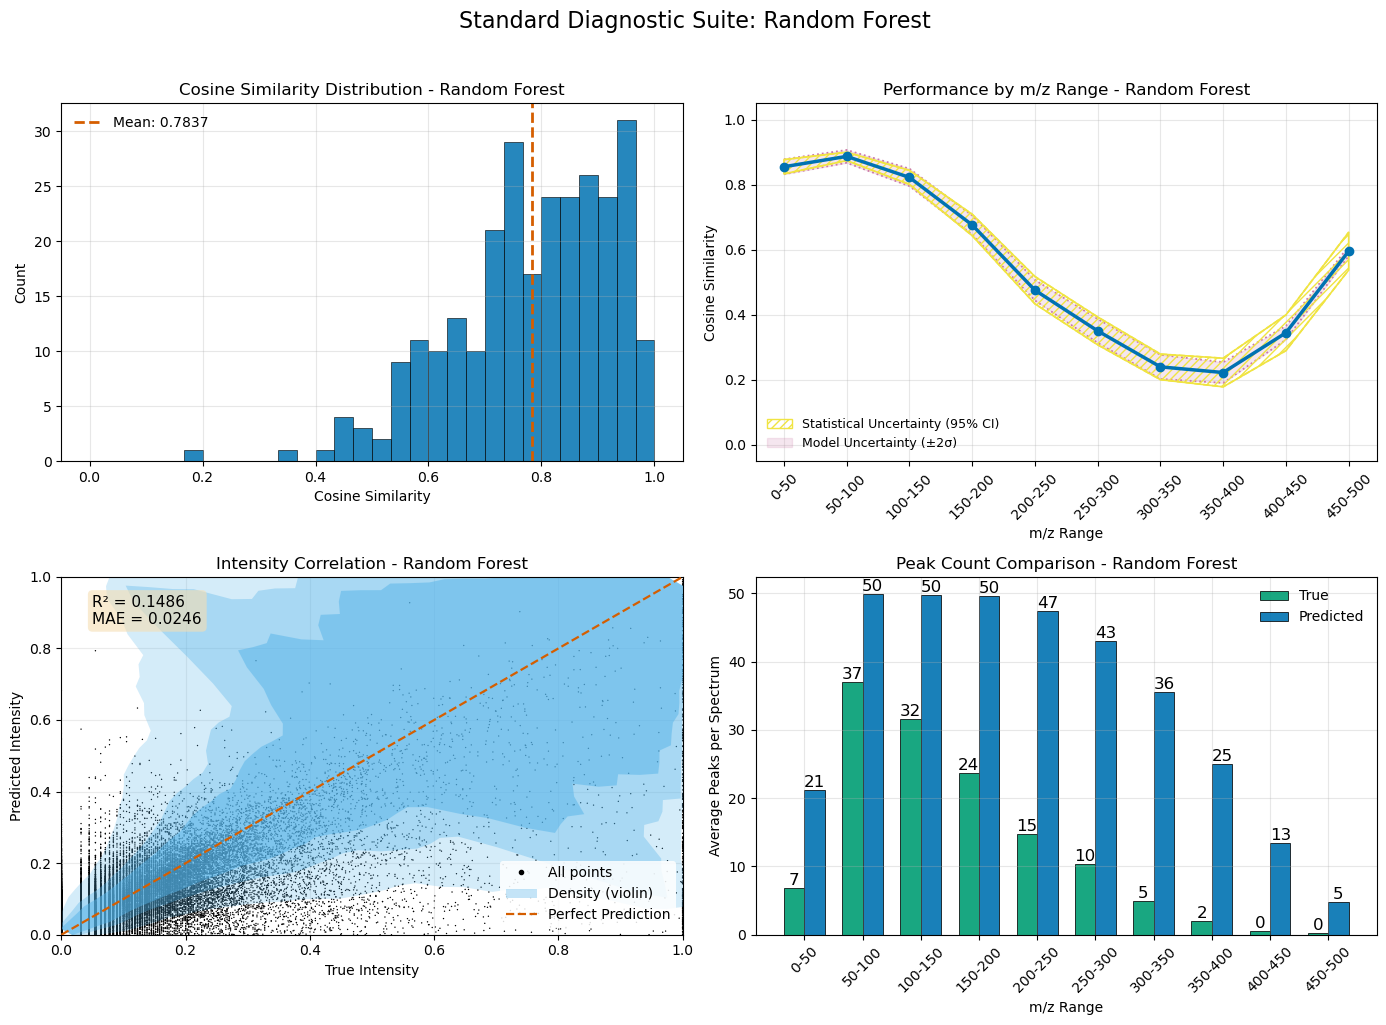


2. Random Spectrum Examples

Selected random examples:
  1. Index 30: Cosine=0.7427, WDP=0.4612
  2. Index 116: Cosine=0.7392, WDP=0.4102
  3. Index 79: Cosine=0.9462, WDP=0.7661
  4. Index 127: Cosine=0.8329, WDP=0.4523


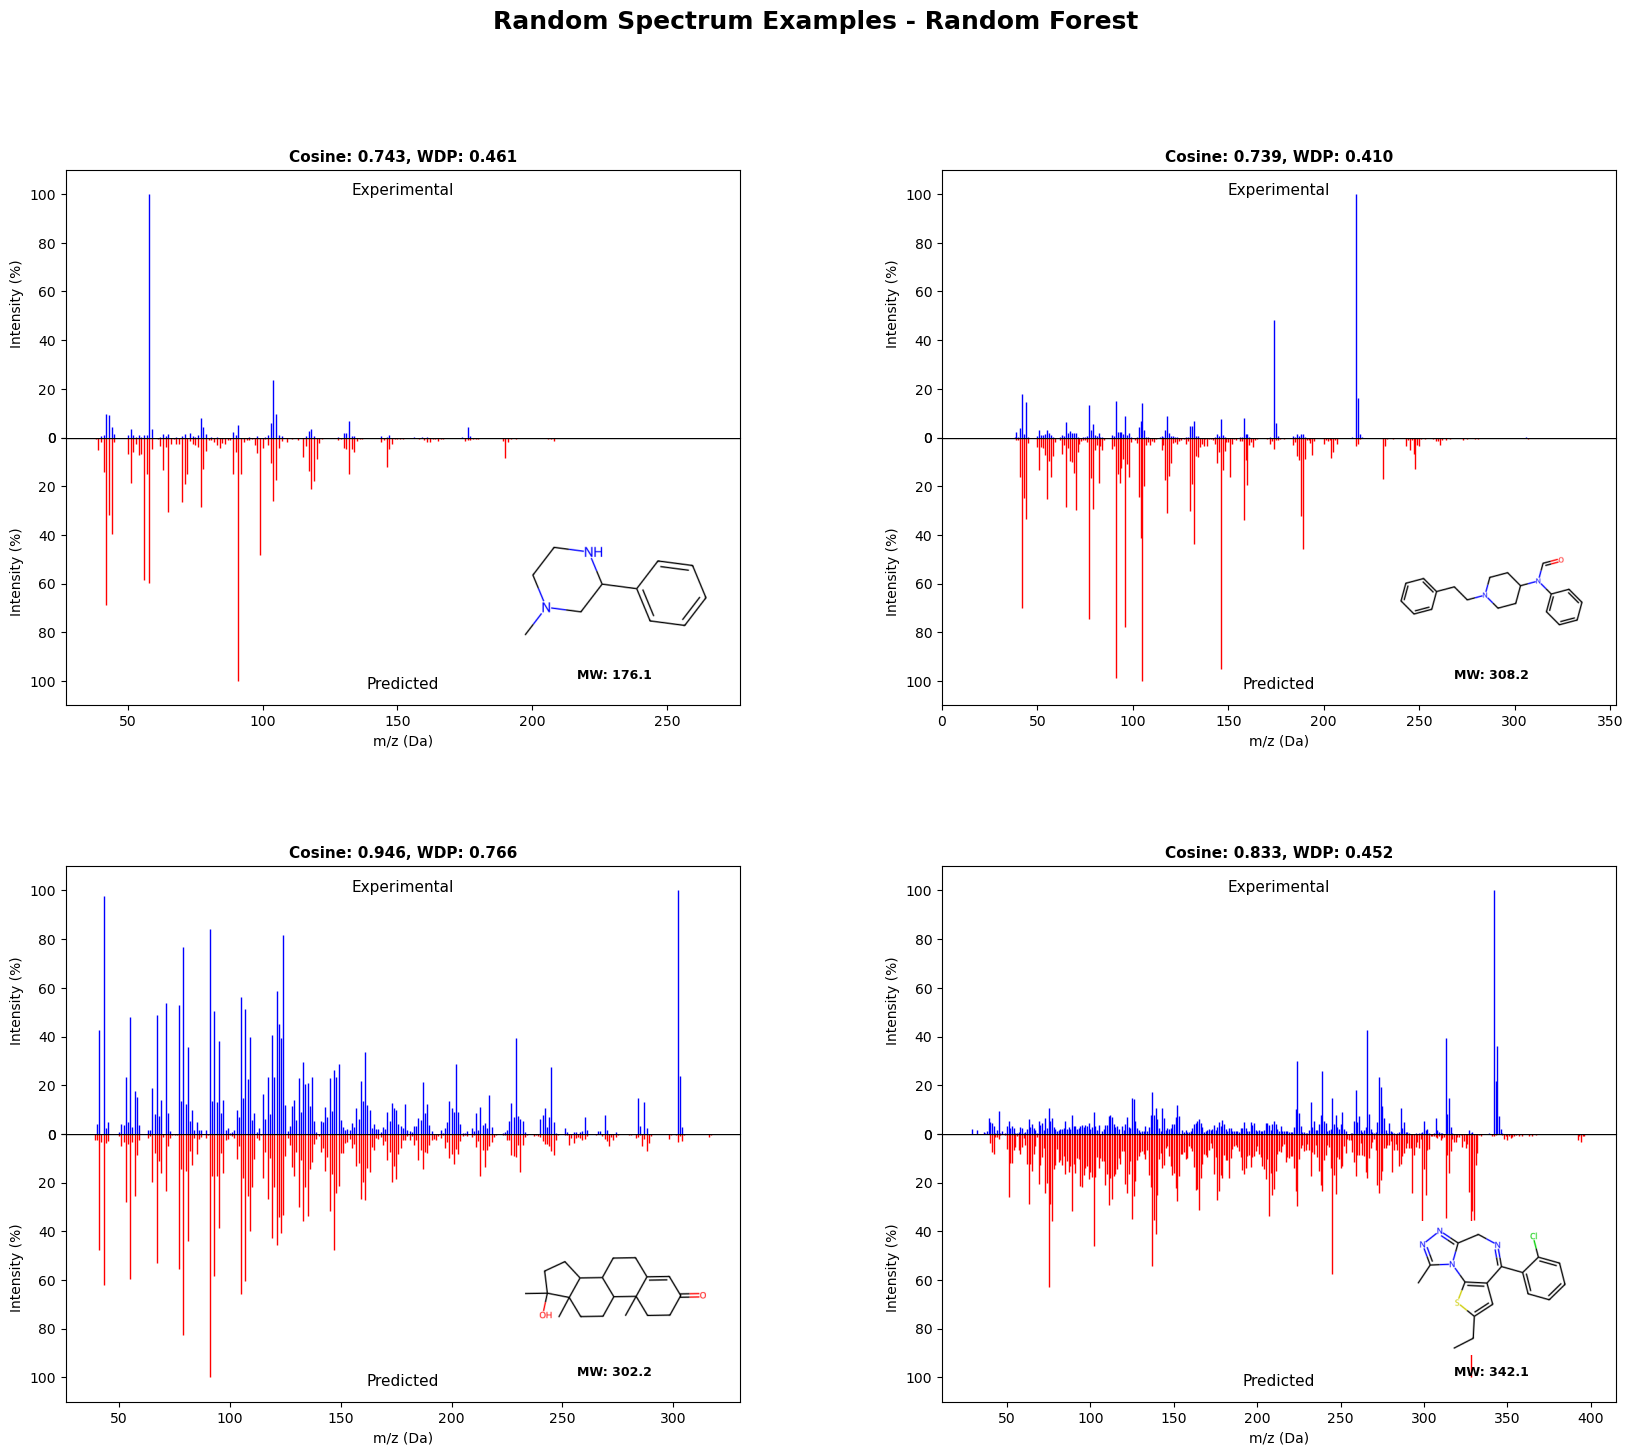


Model saved to ../models/hpj_rf_model.pkl


In [8]:
print("\nTRAINING RANDOM FOREST MODEL")
print("=" * 60)

# Create and train RF model
print("Training Random Forest model...")
rf_model = RandomForestRegressor(
    n_estimators=MASTER_CONFIG['rf']['n_estimators'],
    max_depth=MASTER_CONFIG['rf']['max_depth'],
    min_samples_split=MASTER_CONFIG['rf']['min_samples_split'],
    min_samples_leaf=MASTER_CONFIG['rf']['min_samples_leaf'],
    random_state=MASTER_CONFIG['data']['random_state'],
    n_jobs=MASTER_CONFIG['rf']['n_jobs']
)

print(f"Training on {len(X_train_scaled)} samples...")
rf_model.fit(X_train_scaled, y_train_transformed)
print("RF model trained successfully")

# Evaluate RF model with uncertainty
y_test_pred_rf, rf_tree_predictions = get_model_predictions_with_uncertainty(rf_model, X_test_scaled)
y_test_pred_rf = np.maximum(y_test_pred_rf, 0)  # Ensure non-negative

rf_results = evaluate_model(y_test_transformed, y_test_pred_rf, MASTER_CONFIG, "Random Forest", rf_tree_predictions)

# Generate standard visualizations
print("\nGenerating Standard Visualizations:")
print("1. Standard 2x2 Diagnostic Plots")
visualize_results(rf_results, "Random Forest")

print("\n2. Random Spectrum Examples")
create_spectrum_grid(rf_results, test_smiles, n_examples=4, model_name="Random Forest")

# Save model
model_path = os.path.join(MASTER_CONFIG['paths']['models_dir'], 
                          f"{MASTER_CONFIG['paths']['input_type']}_rf_model.pkl")
with open(model_path, 'wb') as f:
    pickle.dump({'model': rf_model, 'scaler': scaler}, f)
print(f"\nModel saved to {model_path}")

## 9. K-Nearest Neighbors Training

Distance-weighted native multi-output KNN with optimized hyperparameters.

$$\hat{\mathbf{y}}(x) = \sum_{i \in N_k(x)} w_i(x)\,\mathbf{y}_i,\quad w_i=\frac{\kappa(d(x,x_i))}{\sum_j \kappa(d(x,x_j))}$$

```mermaid
flowchart LR
  Xq["Query x"] --> NN["Find optimized N_k(x)"]
  NN --> W["Compute weights (distance/metric)"]
  W --> Avg["Weighted average of neighbor spectra"]
  Avg --> O["ŷ"]
```


TRAINING K-NEAREST NEIGHBORS MODEL (OPTIMIZED)
Training K-Nearest Neighbors model with OPTIMIZED hyperparameters...
Training on 2176 samples...
KNN model trained successfully
Generating predictions...

K-Nearest Neighbors Performance:
  Cosine Similarity: 0.7325
  MSE: 0.0052
  R2 Score: -0.1260
  MAE: 0.0252
  Median AE: 0.0085
  Max Error: 1.0000
  Explained Variance: -0.1199

Generating Standard Visualizations:
1. Standard 2x2 Diagnostic Plots


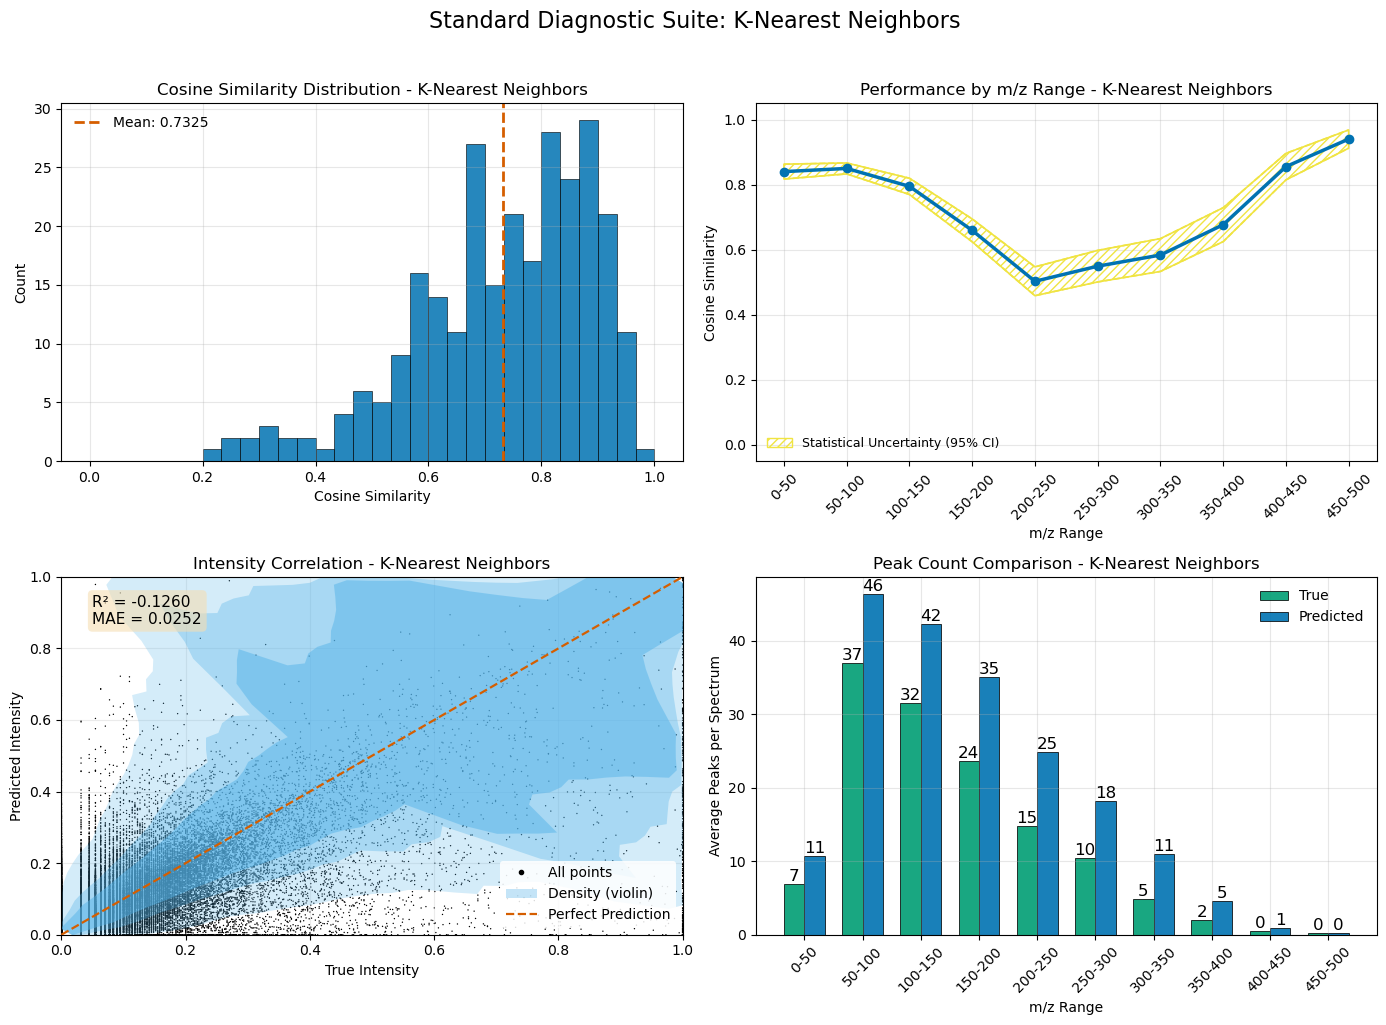


2. Random Spectrum Examples

Selected random examples:
  1. Index 83: Cosine=0.7421, WDP=0.5184
  2. Index 81: Cosine=0.3205, WDP=0.2193
  3. Index 265: Cosine=0.6289, WDP=0.4357
  4. Index 128: Cosine=0.6699, WDP=0.4249


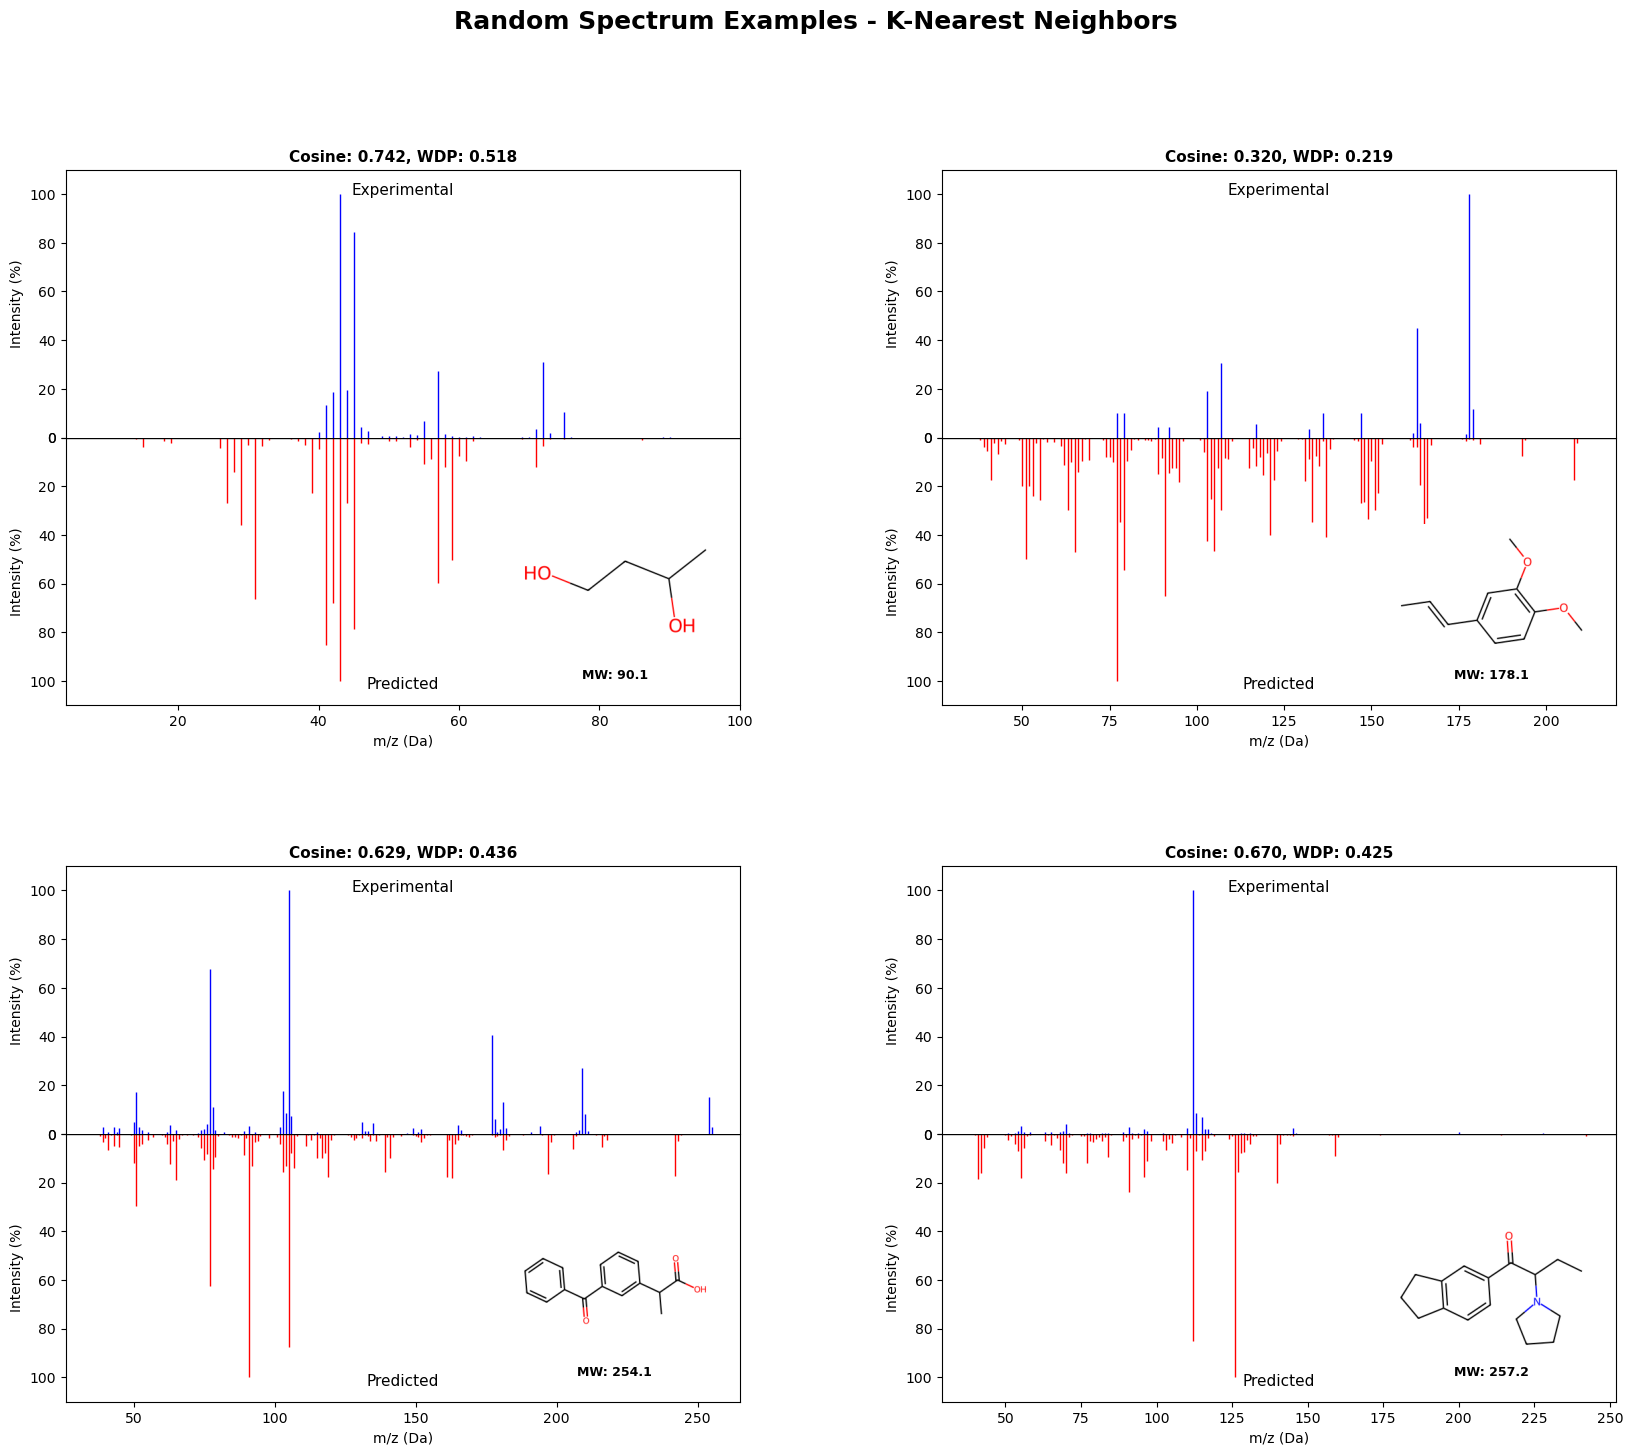


Model saved to ../models/hpj_knn_model.pkl


In [9]:
print("\nTRAINING K-NEAREST NEIGHBORS MODEL (OPTIMIZED)")
print("=" * 60)

# Create KNN model with optimized hyperparameters
print("Training K-Nearest Neighbors model with OPTIMIZED hyperparameters...")
knn_model = KNeighborsRegressor(
    n_neighbors=MASTER_CONFIG['knn']['n_neighbors'],
    weights=MASTER_CONFIG['knn']['weights'],
    algorithm=MASTER_CONFIG['knn']['algorithm'],
    metric=MASTER_CONFIG['knn']['metric'],
    leaf_size=MASTER_CONFIG['knn']['leaf_size'],
    n_jobs=MASTER_CONFIG['knn']['n_jobs']
)

print(f"Training on {len(X_train_scaled)} samples...")
knn_model.fit(X_train_scaled, y_train_transformed)
print("KNN model trained successfully")

# Evaluate KNN model
print("Generating predictions...")
y_test_pred_knn = knn_model.predict(X_test_scaled)
y_test_pred_knn = np.maximum(y_test_pred_knn, 0)  # Ensure non-negative

knn_results = evaluate_model(y_test_transformed, y_test_pred_knn, MASTER_CONFIG, "K-Nearest Neighbors")

# Generate standard visualizations
print("\nGenerating Standard Visualizations:")
print("1. Standard 2x2 Diagnostic Plots")
visualize_results(knn_results, "K-Nearest Neighbors")

print("\n2. Random Spectrum Examples")
create_spectrum_grid(knn_results, test_smiles, n_examples=4, model_name="K-Nearest Neighbors")

# Save model
model_path = os.path.join(MASTER_CONFIG['paths']['models_dir'], 
                          f"{MASTER_CONFIG['paths']['input_type']}_knn_model.pkl")
with open(model_path, 'wb') as f:
    pickle.dump({'model': knn_model, 'scaler': scaler}, f)
print(f"\nModel saved to {model_path}")

## 10. ModularNet Neural Network

Modular architecture with specialized sub-modules combined through attention-based fusion.

### Architecture
- Multiple specialized modules processing input independently
- Global feature extractor for attention computation
- Attention fusion: $\alpha_i = \mathrm{softmax}(W_{attn} h_{global})_i$
- Final output: $\hat{\mathbf{y}} = \sum_{i=1}^{M} \alpha_i\, \mathrm{Module}_i(\mathbf{x})$

```mermaid
flowchart TD
  X["Input x"] --> G["Global encoder h_global"]
  X --> M1["Module 1"]
  X --> M2["Module 2"]
  X --> Mm["Module M"]
  G --> W["Attention weights α = softmax(W_attn h_global)"]
  M1 --> Fuse
  M2 --> Fuse
  Mm --> Fuse
  W --> Fuse
  Fuse["Weighted sum"] --> O["ŷ"]
```


TRAINING MODULARNET
ModularNet parameters: 9,530,836

Training ModularNet...


Epoch 5/100: 100%|██████████| 34/34 [00:01<00:00, 18.71it/s, loss=0.2122]


  Val Loss: 0.2736, Cosine: 0.7329, F1: 0.7384


Epoch 10/100: 100%|██████████| 34/34 [00:01<00:00, 22.91it/s, loss=0.1746]


  Val Loss: 0.2579, Cosine: 0.7478, F1: 0.7517


Epoch 15/100: 100%|██████████| 34/34 [00:01<00:00, 24.89it/s, loss=0.1346]


  Val Loss: 0.2491, Cosine: 0.7562, F1: 0.7609


Epoch 20/100: 100%|██████████| 34/34 [00:01<00:00, 18.44it/s, loss=0.1124]


  Val Loss: 0.2435, Cosine: 0.7625, F1: 0.7658


Epoch 25/100: 100%|██████████| 34/34 [00:01<00:00, 19.60it/s, loss=0.0983]


  Val Loss: 0.2355, Cosine: 0.7690, F1: 0.7689


Epoch 30/100: 100%|██████████| 34/34 [00:00<00:00, 36.05it/s, loss=0.0863]


  Val Loss: 0.2359, Cosine: 0.7693, F1: 0.7729


Epoch 35/100: 100%|██████████| 34/34 [00:01<00:00, 26.67it/s, loss=0.0943]


  Val Loss: 0.2371, Cosine: 0.7710, F1: 0.7728


Epoch 40/100: 100%|██████████| 34/34 [00:01<00:00, 30.08it/s, loss=0.0683]


  Val Loss: 0.2338, Cosine: 0.7732, F1: 0.7759


Epoch 45/100: 100%|██████████| 34/34 [00:01<00:00, 26.85it/s, loss=0.0726]


  Val Loss: 0.2340, Cosine: 0.7729, F1: 0.7761


Epoch 50/100: 100%|██████████| 34/34 [00:01<00:00, 31.58it/s, loss=0.0740]


  Val Loss: 0.2351, Cosine: 0.7701, F1: 0.7797


Epoch 55/100: 100%|██████████| 34/34 [00:00<00:00, 40.66it/s, loss=0.0559]


  Val Loss: 0.2304, Cosine: 0.7760, F1: 0.7781


Epoch 60/100: 100%|██████████| 34/34 [00:01<00:00, 25.09it/s, loss=0.0622]


  Val Loss: 0.2290, Cosine: 0.7783, F1: 0.7807


Epoch 65/100: 100%|██████████| 34/34 [00:01<00:00, 31.77it/s, loss=0.0611]


  Val Loss: 0.2271, Cosine: 0.7800, F1: 0.7820


Epoch 70/100: 100%|██████████| 34/34 [00:00<00:00, 40.22it/s, loss=0.0644]


  Val Loss: 0.2306, Cosine: 0.7772, F1: 0.7820


Epoch 75/100: 100%|██████████| 34/34 [00:01<00:00, 30.38it/s, loss=0.0577]


  Val Loss: 0.2288, Cosine: 0.7780, F1: 0.7816


Epoch 80/100: 100%|██████████| 34/34 [00:01<00:00, 27.40it/s, loss=0.0562]


  Val Loss: 0.2256, Cosine: 0.7820, F1: 0.7852


Epoch 85/100: 100%|██████████| 34/34 [00:01<00:00, 32.39it/s, loss=0.0526]


  Val Loss: 0.2231, Cosine: 0.7823, F1: 0.7838


Epoch 90/100: 100%|██████████| 34/34 [00:01<00:00, 31.66it/s, loss=0.0542]


  Val Loss: 0.2230, Cosine: 0.7823, F1: 0.7872


Epoch 95/100: 100%|██████████| 34/34 [00:01<00:00, 29.43it/s, loss=0.0529]


  Val Loss: 0.2248, Cosine: 0.7822, F1: 0.7848


Epoch 100/100: 100%|██████████| 34/34 [00:01<00:00, 30.34it/s, loss=0.0518]


  Val Loss: 0.2246, Cosine: 0.7822, F1: 0.7845

Training complete. Best validation cosine: 0.7823

ModularNet Performance:
  Cosine Similarity: 0.7691
  MSE: 0.0049
  R2 Score: 0.2186
  MAE: 0.0230
  Median AE: 0.0071
  Max Error: 1.4364
  Explained Variance: 0.2276

Generating Standard Visualizations:
1. Standard 2x2 Diagnostic Plots


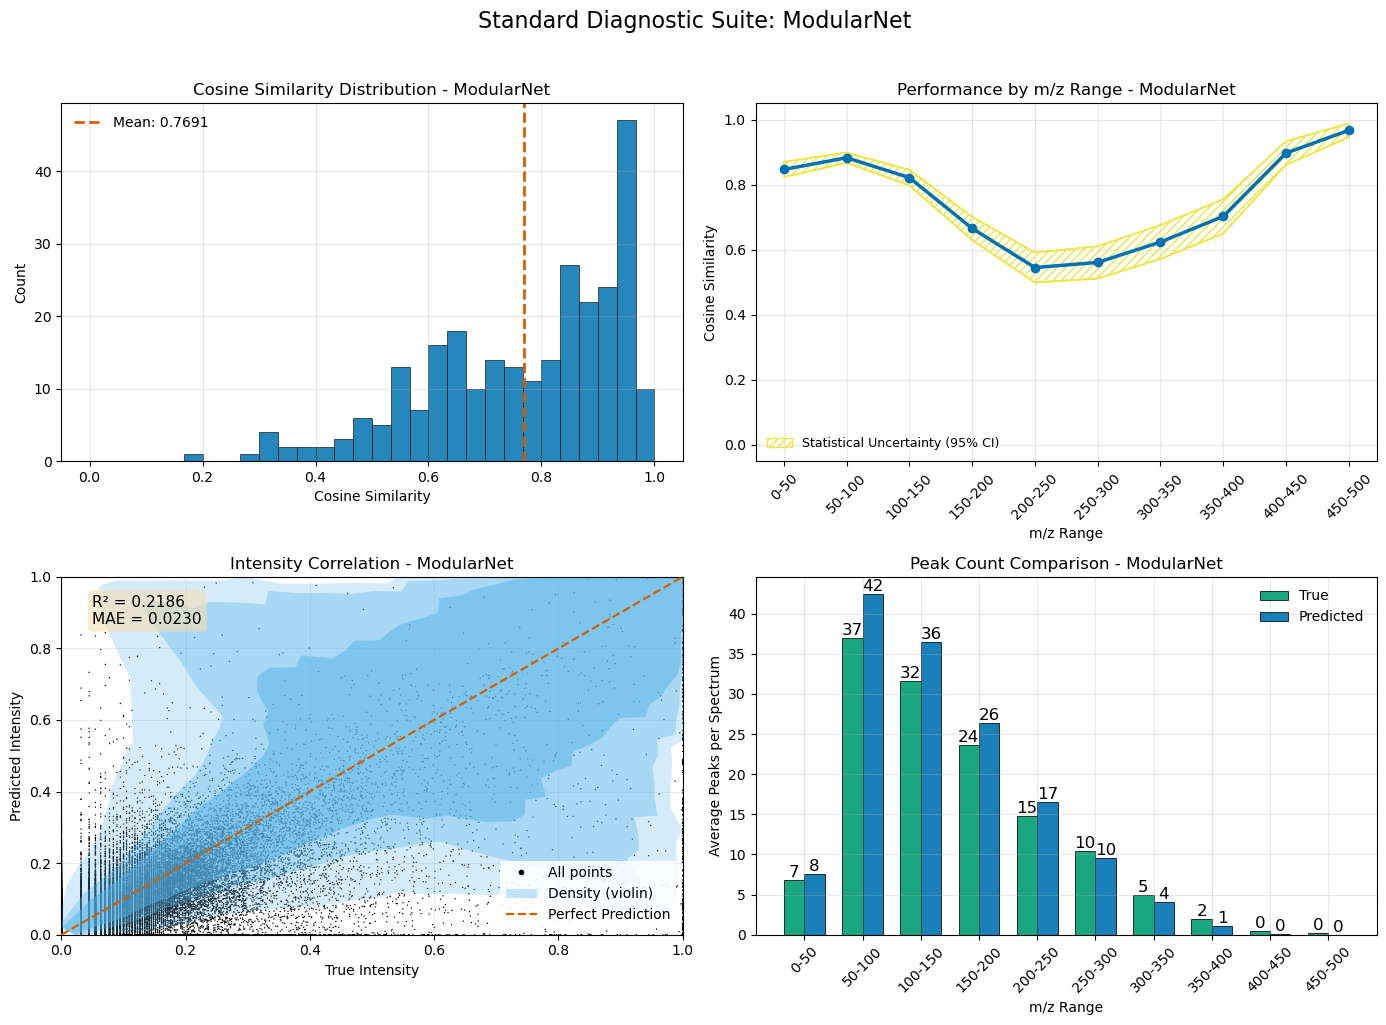


2. Random Spectrum Examples

Selected random examples:
  1. Index 80: Cosine=0.8632, WDP=0.9829
  2. Index 129: Cosine=0.9113, WDP=1.1317
  3. Index 208: Cosine=0.9195, WDP=0.9427
  4. Index 241: Cosine=0.4716, WDP=0.1893


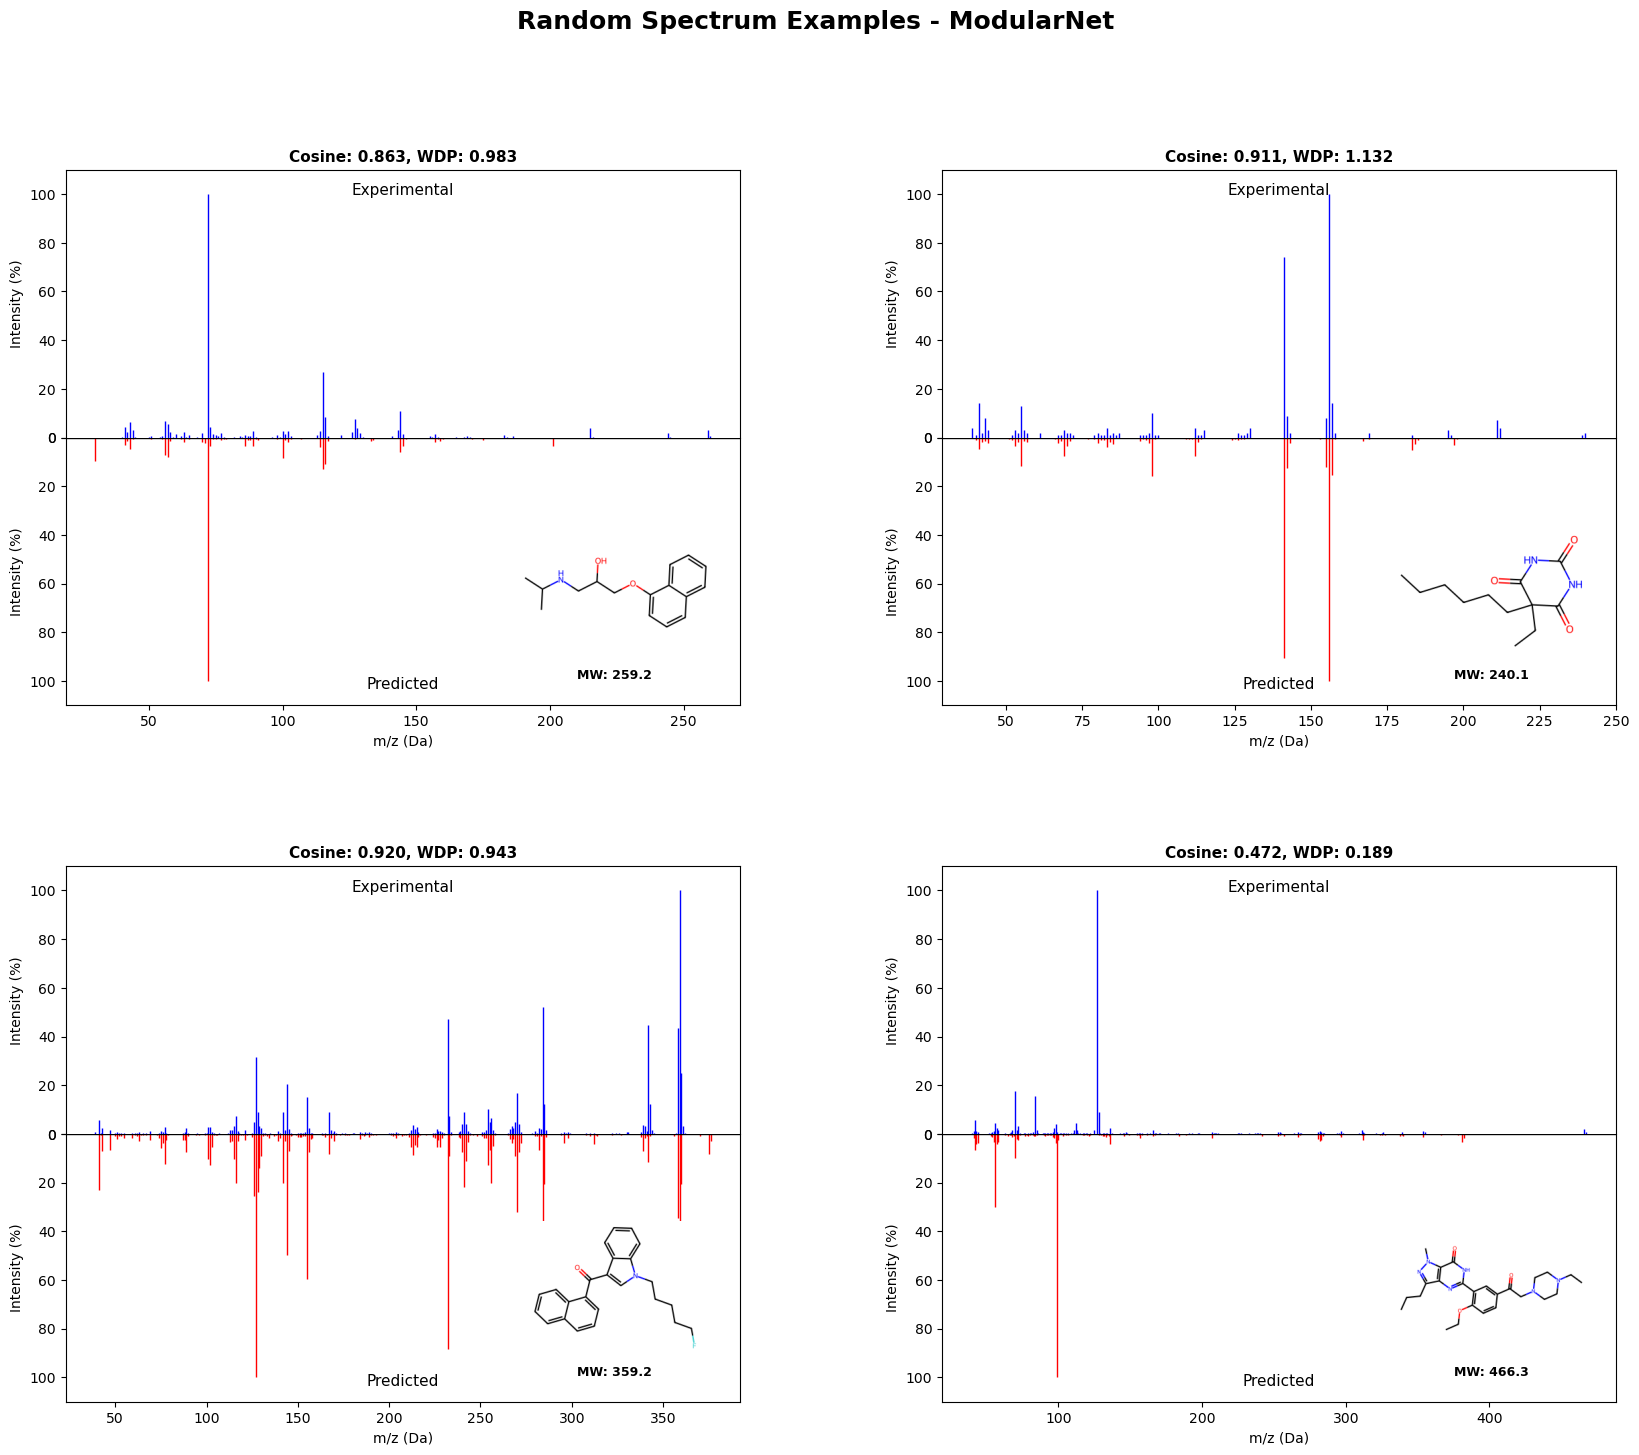


3. Deep Learning Training History


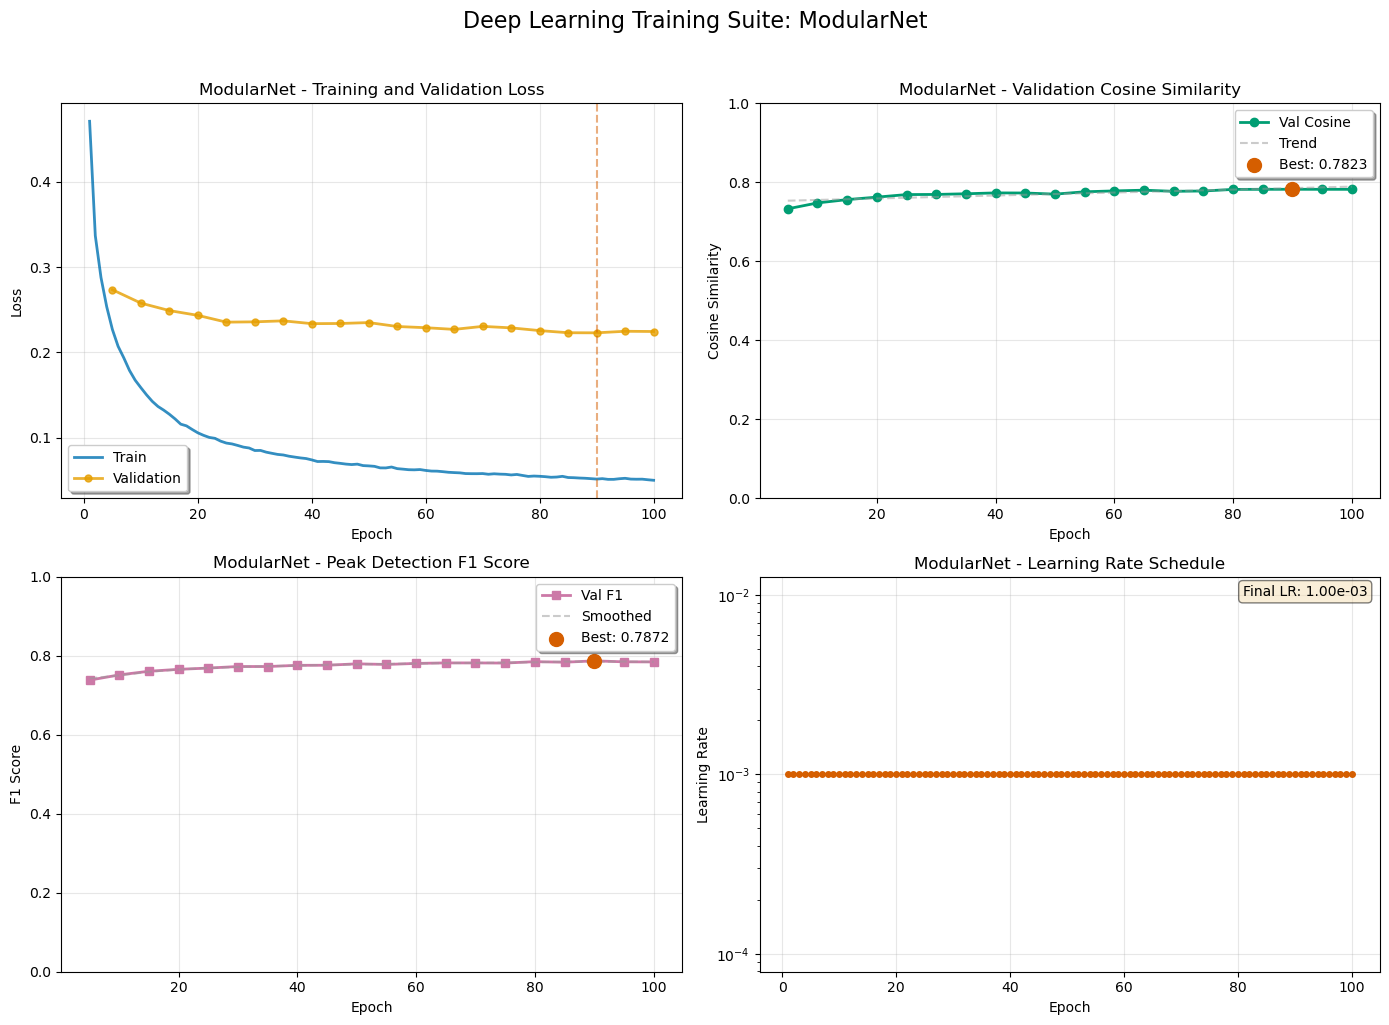

In [10]:
class ModularNet(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        
        num_modules = config['num_modules']
        module_dims = config['module_dims']
        fusion_method = config['fusion_method']
        
        # Global feature extractor
        self.global_encoder = nn.Sequential(
            nn.Linear(input_dim, module_dims[0]),
            nn.BatchNorm1d(module_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        # Specialized modules
        self.specialized_modules = nn.ModuleList()
        
        for i in range(num_modules):
            module_layers = []
            dims = [input_dim] + module_dims
            
            for j in range(len(module_dims)):
                module_layers.extend([
                    nn.Linear(dims[j], dims[j+1]),
                    nn.BatchNorm1d(dims[j+1]),
                    nn.ReLU(),
                    nn.Dropout(0.1)
                ])
            
            module_layers.append(nn.Linear(module_dims[-1], output_dim))
            module_layers.append(nn.ReLU())
            
            self.specialized_modules.append(nn.Sequential(*module_layers))
        
        # Fusion mechanism
        if fusion_method == 'attention':
            self.fusion_attention = nn.Sequential(
                nn.Linear(module_dims[0], num_modules),
                nn.Softmax(dim=1)
            )
        else:
            self.fusion_weights = nn.Parameter(torch.ones(num_modules) / num_modules)
    
    def forward(self, x):
        # Global encoding
        global_features = self.global_encoder(x)
        
        # Get predictions from each module
        module_outputs = []
        for module in self.specialized_modules:
            output = module(x)
            module_outputs.append(output)
        
        module_outputs = torch.stack(module_outputs, dim=1)
        
        # Fusion
        if hasattr(self, 'fusion_attention'):
            attention_weights = self.fusion_attention(global_features)
            attention_weights = attention_weights.unsqueeze(2)
            fused_output = (module_outputs * attention_weights).sum(dim=1)
        else:
            weights = F.softmax(self.fusion_weights, dim=0)
            weights = weights.view(1, -1, 1)
            fused_output = (module_outputs * weights).sum(dim=1)
        
        return fused_output

# Train ModularNet
print("\nTRAINING MODULARNET")
print("=" * 60)

# Create data loaders
train_dataset = TensorDataset(
    torch.from_numpy(X_train_scaled).float(),
    torch.from_numpy(y_train_transformed).float()
)
val_dataset = TensorDataset(
    torch.from_numpy(X_val_scaled).float(),
    torch.from_numpy(y_val_transformed).float()
)

train_loader = DataLoader(train_dataset, batch_size=MASTER_CONFIG['modularnet']['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=MASTER_CONFIG['modularnet']['batch_size'], shuffle=False)

# Initialize model
modularnet_model = ModularNet(input_dim, output_dim, MASTER_CONFIG['modularnet']).to(DEVICE)
print(f"ModularNet parameters: {sum(p.numel() for p in modularnet_model.parameters()):,}")

# Train
modularnet_model, modularnet_history = train_neural_network(
    modularnet_model, train_loader, val_loader, MASTER_CONFIG['modularnet'], "ModularNet"
)

# Evaluate
modularnet_model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test_scaled).float().to(DEVICE)
    y_test_pred_modularnet = modularnet_model(X_test_tensor).cpu().numpy()
    y_test_pred_modularnet = np.maximum(y_test_pred_modularnet, 0)

modularnet_results = evaluate_model(y_test_transformed, y_test_pred_modularnet, MASTER_CONFIG, "ModularNet")

# Generate standard visualizations
print("\nGenerating Standard Visualizations:")
print("1. Standard 2x2 Diagnostic Plots")
visualize_results(modularnet_results, "ModularNet")

print("\n2. Random Spectrum Examples")
create_spectrum_grid(modularnet_results, test_smiles, n_examples=4, model_name="ModularNet")

print("\n3. Deep Learning Training History")
plot_training_history(modularnet_history, "ModularNet")

## 11. HierarchicalPredictionNet

Two-stage prediction: presence then intensity (conditional).

1) Presence (logits) $\mathbf{z}=\mathrm{MLP}_{\mathrm{pres}}(\mathbf{x})$, $\mathbf{p}=\sigma(\mathbf{z})$  
2) Intensity conditioned on presence: $\hat{\mathbf{y}}_{int}=\mathrm{MLP}_{\mathrm{int}}([\mathbf{x};\mathbf{p}])$  
3) Calibration: $\hat{\mathbf{y}}=\hat{\mathbf{y}}_{int}\odot \mathbf{p}\odot \mathrm{Calib}(\hat{\mathbf{y}}_{int})$

Loss: $\mathcal{L}=\mathcal{L}_{\mathrm{mse}}+\mathcal{L}_{\mathrm{cos}}+\mathcal{L}_{\mathrm{sp}}+\mathcal{L}_{\mathrm{pres}}(\mathbf{z},\mathbb{1}[y>\tau])$

```mermaid
flowchart TD
  X["Input x"] --> P["Presence MLP → z → σ → p"]
  X -->|concat p| Cat["[x; p]"]
  Cat --> I["Intensity MLP → ReLU"]
  I --> Cal["Calibration σ"]
  P --> Gate
  Cal --> Mult
  I --> Mult
  P --> Mult
  Mult["⊙ with p and calib"] --> O["ŷ"]
```


TRAINING HIERARCHICALPREDICTIONNET
HierarchicalPredictionNet parameters: 8,307,692

Training HierarchicalPredictionNet...


Epoch 5/100: 100%|██████████| 34/34 [00:00<00:00, 53.99it/s, loss=0.4020]


  Val Loss: 0.2775, Cosine: 0.7322, F1: 0.7252


Epoch 10/100: 100%|██████████| 34/34 [00:00<00:00, 45.35it/s, loss=0.2839]


  Val Loss: 0.2498, Cosine: 0.7588, F1: 0.7382


Epoch 15/100: 100%|██████████| 34/34 [00:00<00:00, 64.22it/s, loss=0.3040]


  Val Loss: 0.2432, Cosine: 0.7626, F1: 0.7503


Epoch 20/100: 100%|██████████| 34/34 [00:00<00:00, 48.77it/s, loss=0.2545]


  Val Loss: 0.2398, Cosine: 0.7687, F1: 0.7573


Epoch 25/100: 100%|██████████| 34/34 [00:00<00:00, 37.20it/s, loss=0.2317]


  Val Loss: 0.2298, Cosine: 0.7750, F1: 0.7614


Epoch 30/100: 100%|██████████| 34/34 [00:00<00:00, 44.63it/s, loss=0.2035]


  Val Loss: 0.2325, Cosine: 0.7747, F1: 0.7673


Epoch 35/100: 100%|██████████| 34/34 [00:00<00:00, 38.58it/s, loss=0.1696]


  Val Loss: 0.2278, Cosine: 0.7803, F1: 0.7679


Epoch 40/100: 100%|██████████| 34/34 [00:00<00:00, 50.78it/s, loss=0.1867]


  Val Loss: 0.2250, Cosine: 0.7801, F1: 0.7723


Epoch 45/100: 100%|██████████| 34/34 [00:00<00:00, 44.66it/s, loss=0.1691]


  Val Loss: 0.2275, Cosine: 0.7774, F1: 0.7745


Epoch 50/100: 100%|██████████| 34/34 [00:01<00:00, 24.34it/s, loss=0.1748]


  Val Loss: 0.2227, Cosine: 0.7825, F1: 0.7786


Epoch 55/100: 100%|██████████| 34/34 [00:01<00:00, 32.89it/s, loss=0.1536]


  Val Loss: 0.2228, Cosine: 0.7829, F1: 0.7789


Epoch 60/100: 100%|██████████| 34/34 [00:00<00:00, 53.35it/s, loss=0.1605]


  Val Loss: 0.2207, Cosine: 0.7859, F1: 0.7806


Epoch 65/100: 100%|██████████| 34/34 [00:00<00:00, 58.31it/s, loss=0.1463]


  Val Loss: 0.2250, Cosine: 0.7817, F1: 0.7817


Epoch 70/100: 100%|██████████| 34/34 [00:00<00:00, 34.77it/s, loss=0.1371]


  Val Loss: 0.2222, Cosine: 0.7834, F1: 0.7849


Epoch 75/100: 100%|██████████| 34/34 [00:00<00:00, 67.02it/s, loss=0.1480]


  Val Loss: 0.2260, Cosine: 0.7804, F1: 0.7855


Epoch 80/100: 100%|██████████| 34/34 [00:00<00:00, 62.17it/s, loss=0.1445]


  Val Loss: 0.2210, Cosine: 0.7842, F1: 0.7876


Epoch 85/100: 100%|██████████| 34/34 [00:00<00:00, 64.31it/s, loss=0.1434]


  Val Loss: 0.2243, Cosine: 0.7824, F1: 0.7884


Epoch 90/100: 100%|██████████| 34/34 [00:00<00:00, 47.75it/s, loss=0.1341]


  Val Loss: 0.2204, Cosine: 0.7853, F1: 0.7921


Epoch 95/100: 100%|██████████| 34/34 [00:00<00:00, 60.10it/s, loss=0.1176]


  Val Loss: 0.2163, Cosine: 0.7898, F1: 0.7920


Epoch 100/100: 100%|██████████| 34/34 [00:00<00:00, 39.87it/s, loss=0.1388]


  Val Loss: 0.2175, Cosine: 0.7889, F1: 0.7929

Training complete. Best validation cosine: 0.7898

HierarchicalPredictionNet Performance:
  Cosine Similarity: 0.7770
  MSE: 0.0049
  R2 Score: 0.0440
  MAE: 0.0240
  Median AE: 0.0084
  Max Error: 1.4692
  Explained Variance: 0.0505

Generating Standard Visualizations:
1. Standard 2x2 Diagnostic Plots


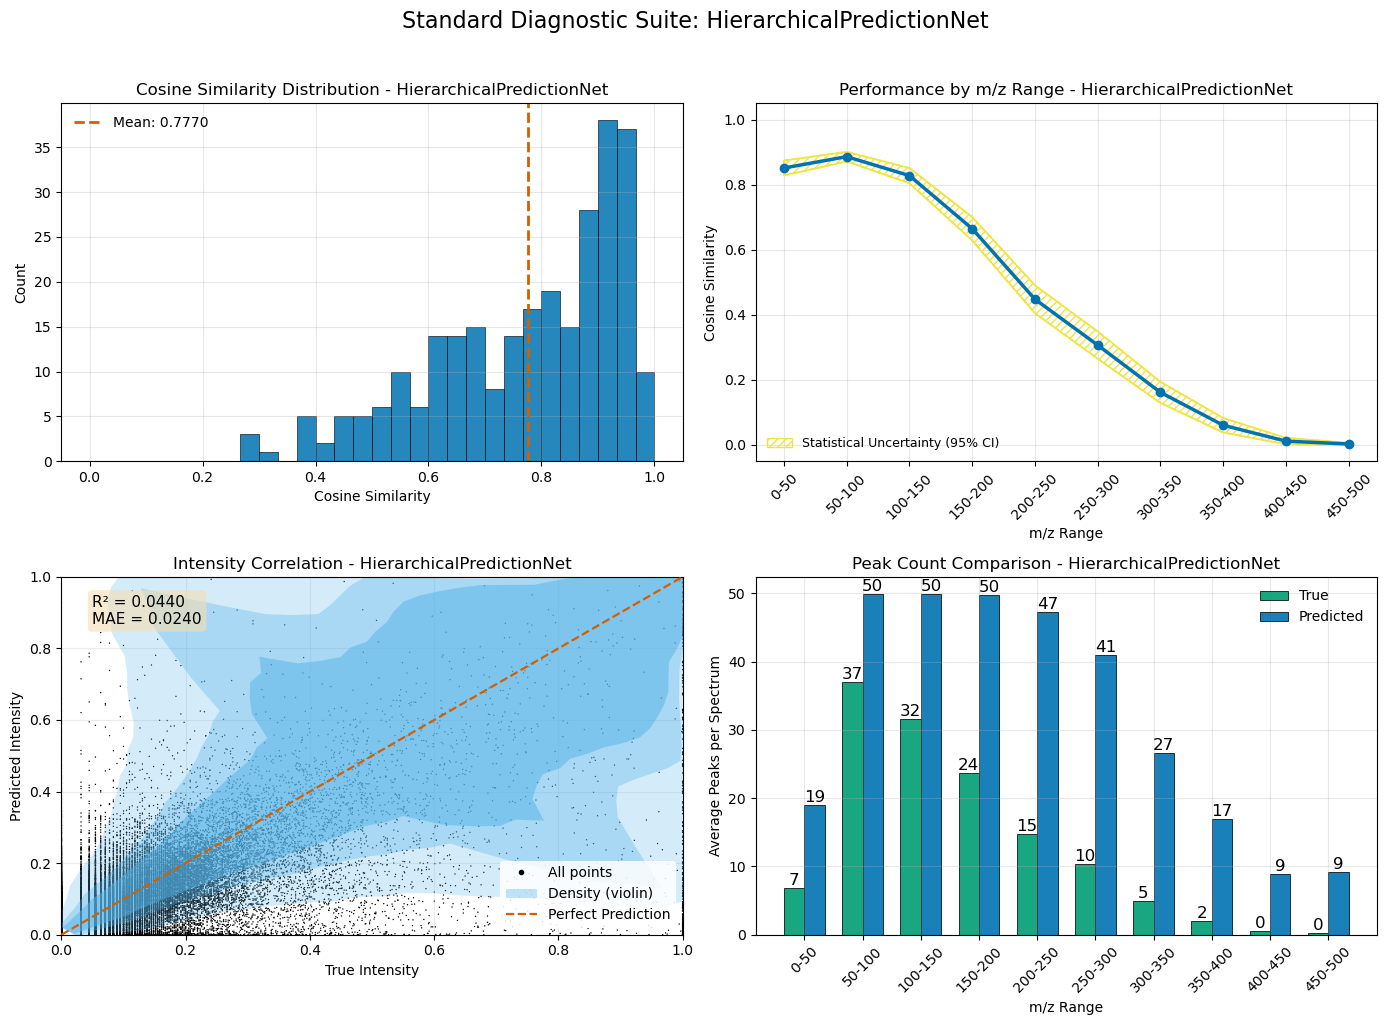


2. Random Spectrum Examples

Selected random examples:
  1. Index 95: Cosine=0.6709, WDP=0.4046
  2. Index 211: Cosine=0.9655, WDP=0.8226
  3. Index 53: Cosine=0.8702, WDP=0.5246
  4. Index 75: Cosine=0.9028, WDP=0.9791


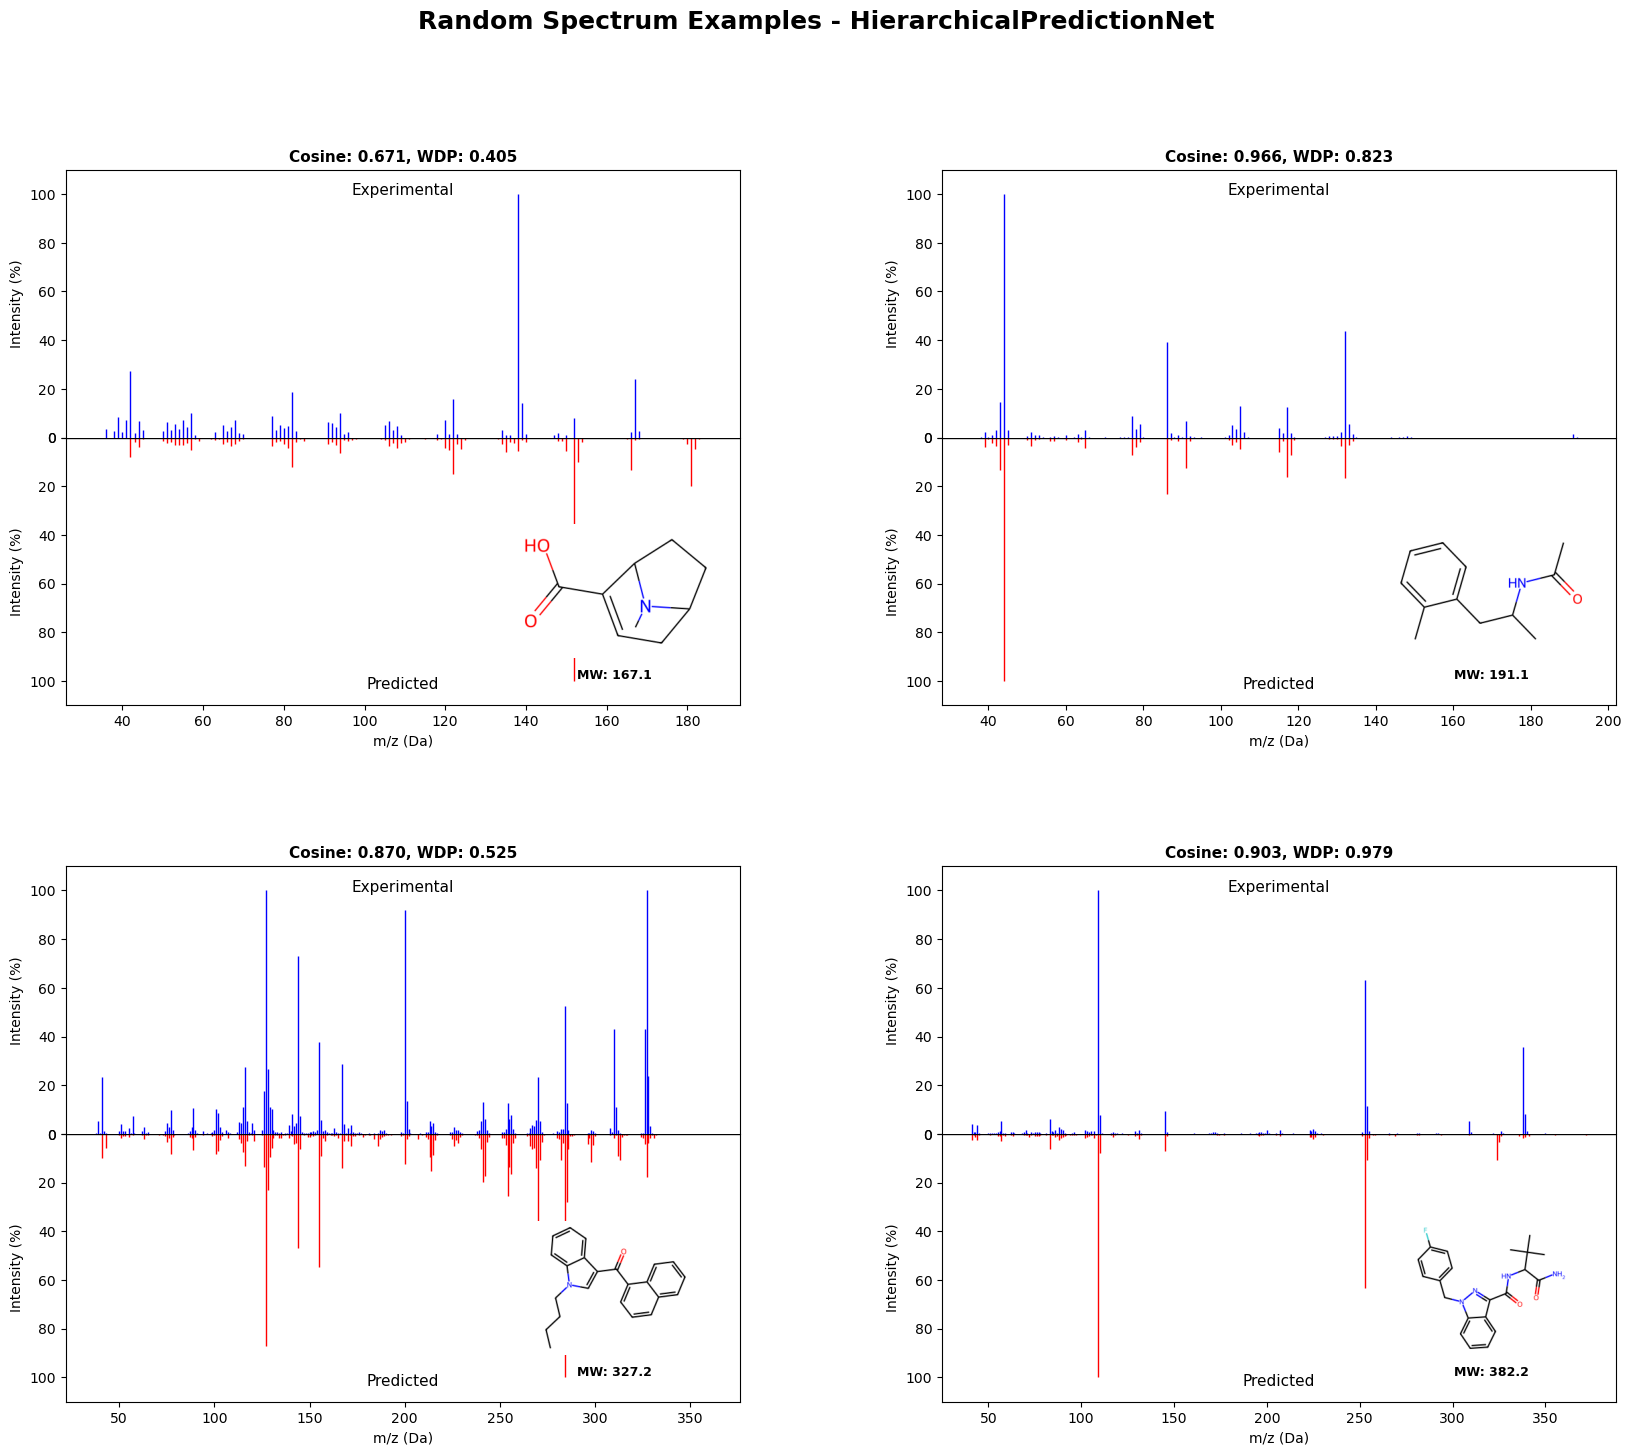


3. Deep Learning Training History


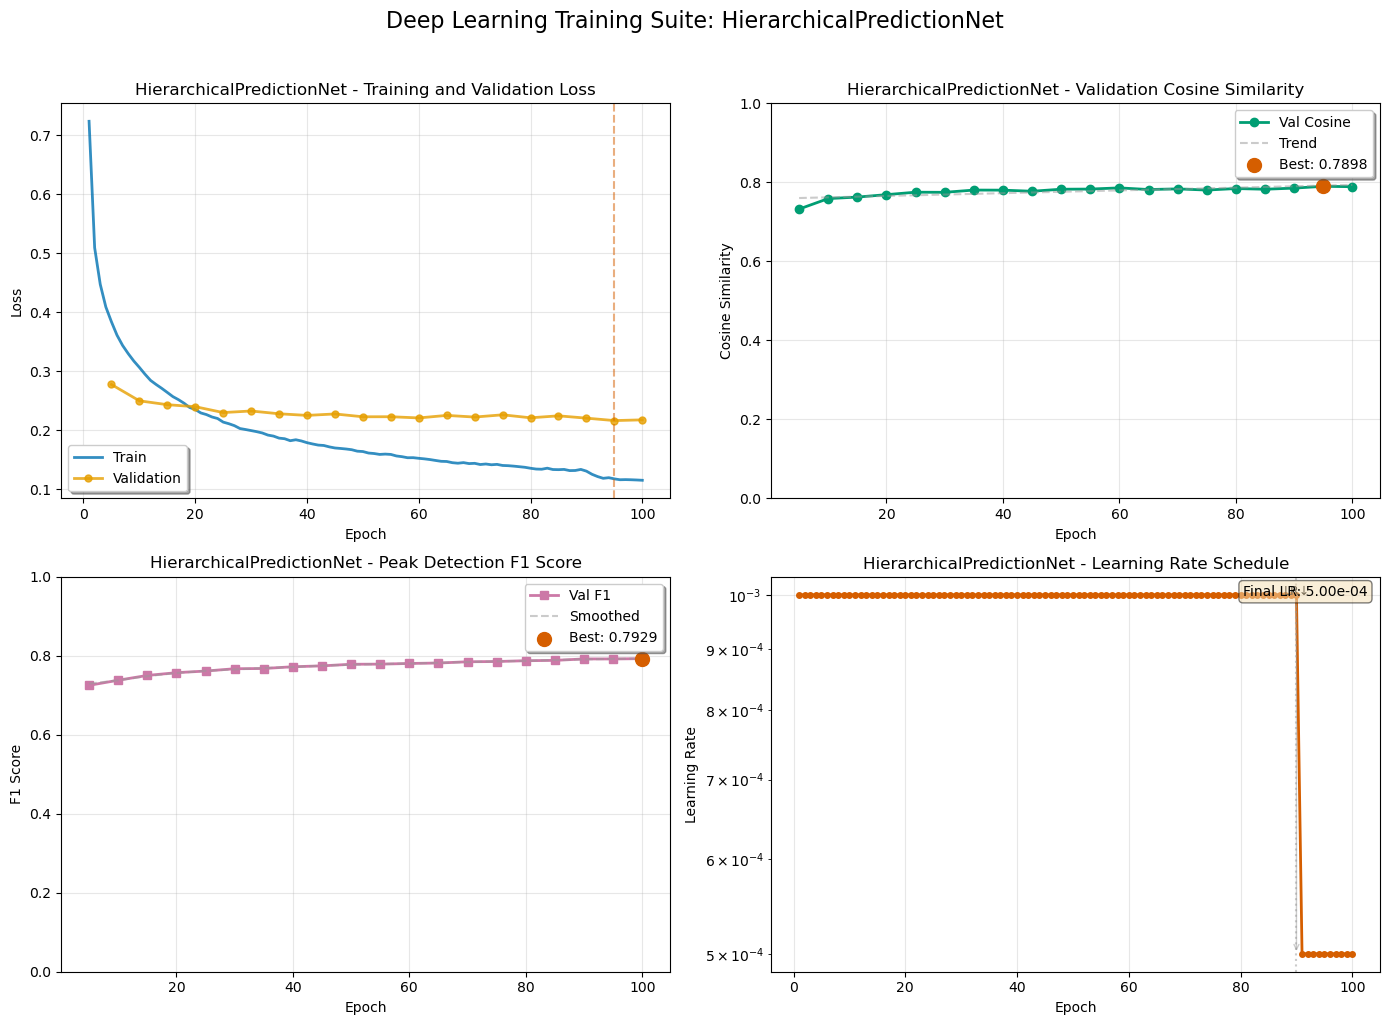

In [11]:
class HierarchicalPredictionNet(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        
        presence_hidden = config['presence_hidden']
        intensity_hidden = config['intensity_hidden']
        self.presence_threshold = config['presence_threshold']
        conditional_dropout = config['conditional_dropout']
        
        # Stage 1: Presence prediction
        presence_layers = []
        dims = [input_dim] + presence_hidden
        
        for i in range(len(presence_hidden)):
            presence_layers.extend([
                nn.Linear(dims[i], dims[i+1]),
                nn.BatchNorm1d(dims[i+1]),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
        
        presence_layers.append(nn.Linear(presence_hidden[-1], output_dim))
        self.presence_net = nn.Sequential(*presence_layers)
        
        # Stage 2: Intensity prediction (conditioned on presence)
        intensity_input_dim = input_dim + output_dim
        
        intensity_layers = []
        dims = [intensity_input_dim] + intensity_hidden
        
        for i in range(len(intensity_hidden)):
            intensity_layers.extend([
                nn.Linear(dims[i], dims[i+1]),
                nn.BatchNorm1d(dims[i+1]),
                nn.ReLU(),
                nn.Dropout(conditional_dropout)
            ])
        
        intensity_layers.append(nn.Linear(intensity_hidden[-1], output_dim))
        intensity_layers.append(nn.ReLU())
        self.intensity_net = nn.Sequential(*intensity_layers)
        
        # Calibration layer
        self.calibration = nn.Sequential(
            nn.Linear(output_dim, output_dim),
            nn.Sigmoid()
        )
        
        self.hierarchical_forward = True  # Flag for training framework
    
    def forward(self, x, return_presence=False):
        # Stage 1: Predict presence
        presence_logits = self.presence_net(x)
        presence_probs = torch.sigmoid(presence_logits)
        
        # Stage 2: Predict intensities conditioned on presence
        conditional_input = torch.cat([x, presence_probs], dim=1)
        intensities = self.intensity_net(conditional_input)
        
        # Calibrate final output
        calibration_weights = self.calibration(intensities)
        
        # Combine
        output = intensities * presence_probs * calibration_weights
        
        if return_presence:
            return output, presence_logits
        return output

# Train HierarchicalPredictionNet
print("\nTRAINING HIERARCHICALPREDICTIONNET")
print("=" * 60)

# Initialize model
hierarchical_model = HierarchicalPredictionNet(input_dim, output_dim, MASTER_CONFIG['hierarchical']).to(DEVICE)
print(f"HierarchicalPredictionNet parameters: {sum(p.numel() for p in hierarchical_model.parameters()):,}")

# Train
hierarchical_model, hierarchical_history = train_neural_network(
    hierarchical_model, train_loader, val_loader, MASTER_CONFIG['hierarchical'], "HierarchicalPredictionNet"
)

# Evaluate
hierarchical_model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test_scaled).float().to(DEVICE)
    y_test_pred_hierarchical = hierarchical_model(X_test_tensor, return_presence=False).cpu().numpy()
    y_test_pred_hierarchical = np.maximum(y_test_pred_hierarchical, 0)

hierarchical_results = evaluate_model(y_test_transformed, y_test_pred_hierarchical, MASTER_CONFIG, "HierarchicalPredictionNet")

# Generate standard visualizations
print("\nGenerating Standard Visualizations:")
print("1. Standard 2x2 Diagnostic Plots")
visualize_results(hierarchical_results, "HierarchicalPredictionNet")

print("\n2. Random Spectrum Examples")
create_spectrum_grid(hierarchical_results, test_smiles, n_examples=4, model_name="HierarchicalPredictionNet")

print("\n3. Deep Learning Training History")
plot_training_history(hierarchical_history, "HierarchicalPredictionNet")

## 12. SparseGatedNet

Specialized architecture for handling extreme sparsity (≈74% zeros).

Hidden gating layer:
$$\mathbf{g}=\sigma(\mathrm{GateMLP}(\mathbf{h}))/T,\quad
\mathbf{o}=\mathbf{g}\odot \mathrm{DensePath}(\mathbf{h})+(1-\mathbf{g})\odot \mathrm{SparsePath}(\mathbf{h}).$$
Output mixture:
$$\hat{\mathbf{y}}=\sigma(\mathbf{W}_g\mathbf{h})\odot \hat{\mathbf{y}}^{\text{dense}}+\big(1-\sigma(\mathbf{W}_g\mathbf{h})\big)\odot 0.1\,\hat{\mathbf{y}}^{\text{sparse}}.$$

```mermaid
flowchart LR
  H["Hidden h"] --> Gate["GateMLP → σ/T"]
  H --> Dense["DensePath"]
  H --> Sparse["SparsePath"]
  Gate --> MixH["g ⊙ Dense + (1−g) ⊙ Sparse"]
  MixH --> OutGate["Output gate σ(W_g h)"]
  MixH --> Yd["ŷ_dense"]
  MixH --> Ys["ŷ_sparse"]
  OutGate --> MixY["gate ⊙ ŷ_dense + (1−gate) ⊙ 0.1·ŷ_sparse"]
  MixY --> O["ŷ"]
```


TRAINING SPARSEGATEDNET
SparseGatedNet parameters: 11,378,652

Training SparseGatedNet...


Epoch 5/100: 100%|██████████| 34/34 [00:00<00:00, 36.56it/s, loss=0.2635]


  Val Loss: 0.2930, Cosine: 0.7179, F1: 0.7035


Epoch 10/100: 100%|██████████| 34/34 [00:00<00:00, 34.11it/s, loss=0.2195]


  Val Loss: 0.2703, Cosine: 0.7379, F1: 0.7421


Epoch 15/100: 100%|██████████| 34/34 [00:00<00:00, 35.48it/s, loss=0.1651]


  Val Loss: 0.2591, Cosine: 0.7484, F1: 0.7477


Epoch 20/100: 100%|██████████| 34/34 [00:00<00:00, 40.56it/s, loss=0.1492]


  Val Loss: 0.2459, Cosine: 0.7581, F1: 0.7634


Epoch 25/100: 100%|██████████| 34/34 [00:01<00:00, 24.19it/s, loss=0.1263]


  Val Loss: 0.2441, Cosine: 0.7593, F1: 0.7641


Epoch 30/100: 100%|██████████| 34/34 [00:01<00:00, 29.10it/s, loss=0.1178]


  Val Loss: 0.2362, Cosine: 0.7708, F1: 0.7686


Epoch 35/100: 100%|██████████| 34/34 [00:01<00:00, 22.42it/s, loss=0.0913]


  Val Loss: 0.2385, Cosine: 0.7682, F1: 0.7713


Epoch 40/100: 100%|██████████| 34/34 [00:01<00:00, 29.22it/s, loss=0.0904]


  Val Loss: 0.2361, Cosine: 0.7698, F1: 0.7729


Epoch 45/100: 100%|██████████| 34/34 [00:00<00:00, 48.20it/s, loss=0.0869]


  Val Loss: 0.2303, Cosine: 0.7764, F1: 0.7788


Epoch 50/100: 100%|██████████| 34/34 [00:00<00:00, 37.69it/s, loss=0.0797]


  Val Loss: 0.2260, Cosine: 0.7765, F1: 0.7766


Epoch 55/100: 100%|██████████| 34/34 [00:00<00:00, 39.97it/s, loss=0.0775]


  Val Loss: 0.2345, Cosine: 0.7723, F1: 0.7745


Epoch 60/100: 100%|██████████| 34/34 [00:00<00:00, 34.67it/s, loss=0.0682]


  Val Loss: 0.2338, Cosine: 0.7709, F1: 0.7770


Epoch 65/100: 100%|██████████| 34/34 [00:00<00:00, 38.03it/s, loss=0.0794]


  Val Loss: 0.2338, Cosine: 0.7707, F1: 0.7794


Epoch 70/100: 100%|██████████| 34/34 [00:00<00:00, 41.40it/s, loss=0.0734]


  Val Loss: 0.2310, Cosine: 0.7730, F1: 0.7789


Epoch 75/100: 100%|██████████| 34/34 [00:00<00:00, 41.21it/s, loss=0.0691]


  Val Loss: 0.2267, Cosine: 0.7773, F1: 0.7787


Epoch 80/100: 100%|██████████| 34/34 [00:00<00:00, 43.56it/s, loss=0.0597]


  Val Loss: 0.2242, Cosine: 0.7806, F1: 0.7815


Epoch 85/100: 100%|██████████| 34/34 [00:00<00:00, 40.52it/s, loss=0.0728]


  Val Loss: 0.2242, Cosine: 0.7779, F1: 0.7813


Epoch 90/100: 100%|██████████| 34/34 [00:00<00:00, 35.23it/s, loss=0.0556]


  Val Loss: 0.2269, Cosine: 0.7770, F1: 0.7798


Epoch 95/100: 100%|██████████| 34/34 [00:00<00:00, 46.81it/s, loss=0.0529]


  Val Loss: 0.2264, Cosine: 0.7789, F1: 0.7816


Epoch 100/100: 100%|██████████| 34/34 [00:01<00:00, 26.76it/s, loss=0.0515]


  Val Loss: 0.2244, Cosine: 0.7821, F1: 0.7829

Training complete. Best validation cosine: 0.7821

SparseGatedNet Performance:
  Cosine Similarity: 0.7674
  MSE: 0.0050
  R2 Score: 0.2640
  MAE: 0.0236
  Median AE: 0.0080
  Max Error: 1.4126
  Explained Variance: 0.2730

Generating Standard Visualizations:
1. Standard 2x2 Diagnostic Plots


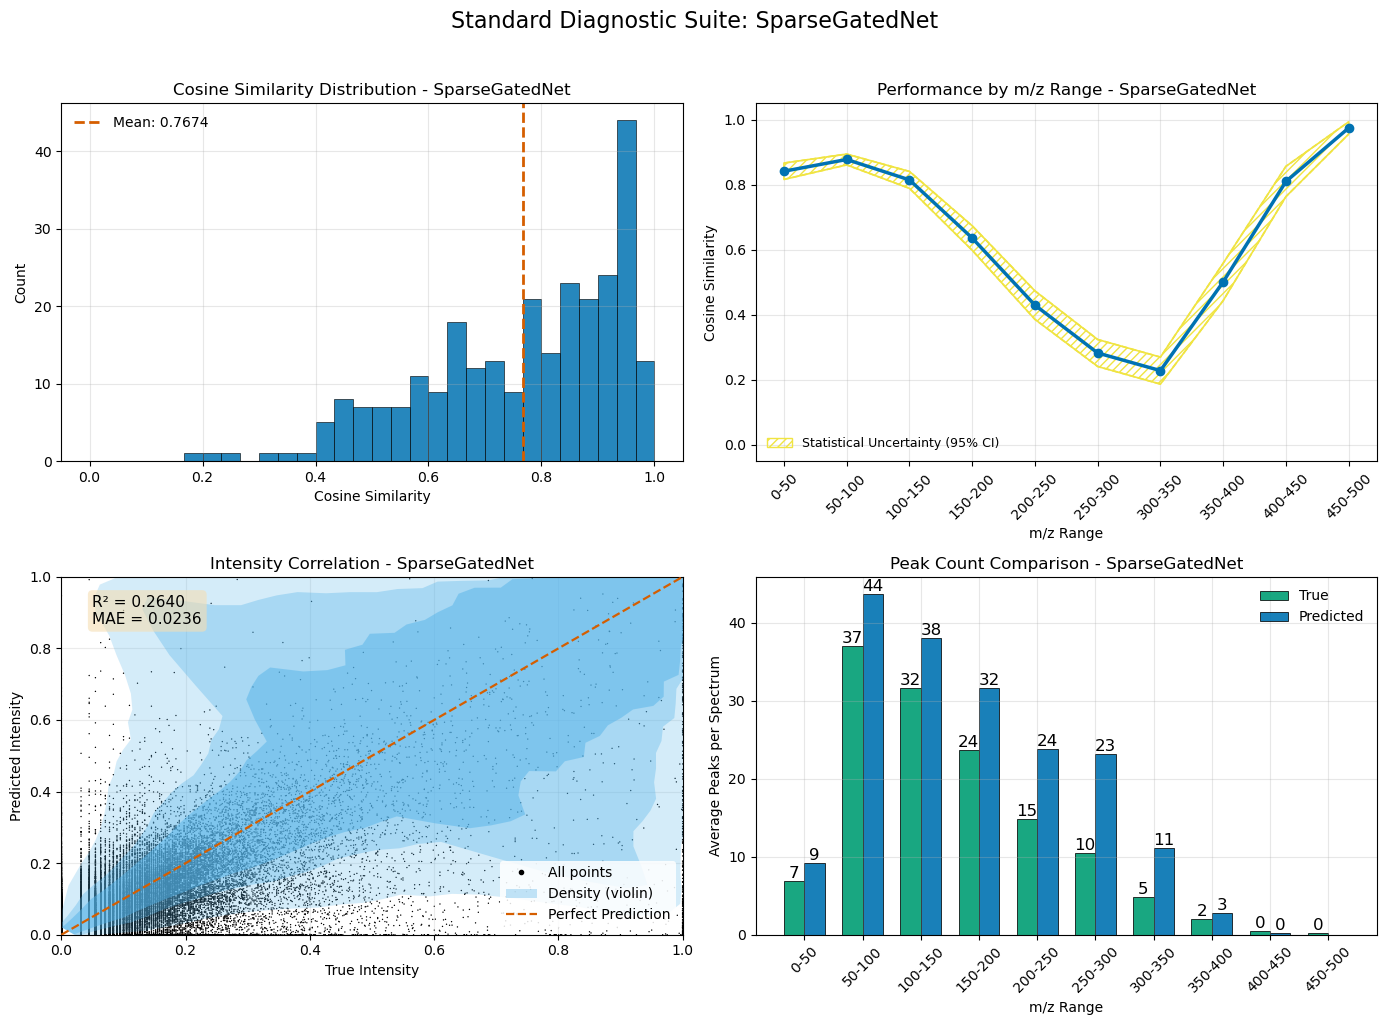


2. Random Spectrum Examples

Selected random examples:
  1. Index 2: Cosine=0.8544, WDP=0.6316
  2. Index 169: Cosine=0.9769, WDP=1.3529
  3. Index 178: Cosine=0.6544, WDP=0.3424
  4. Index 194: Cosine=0.7604, WDP=0.3572


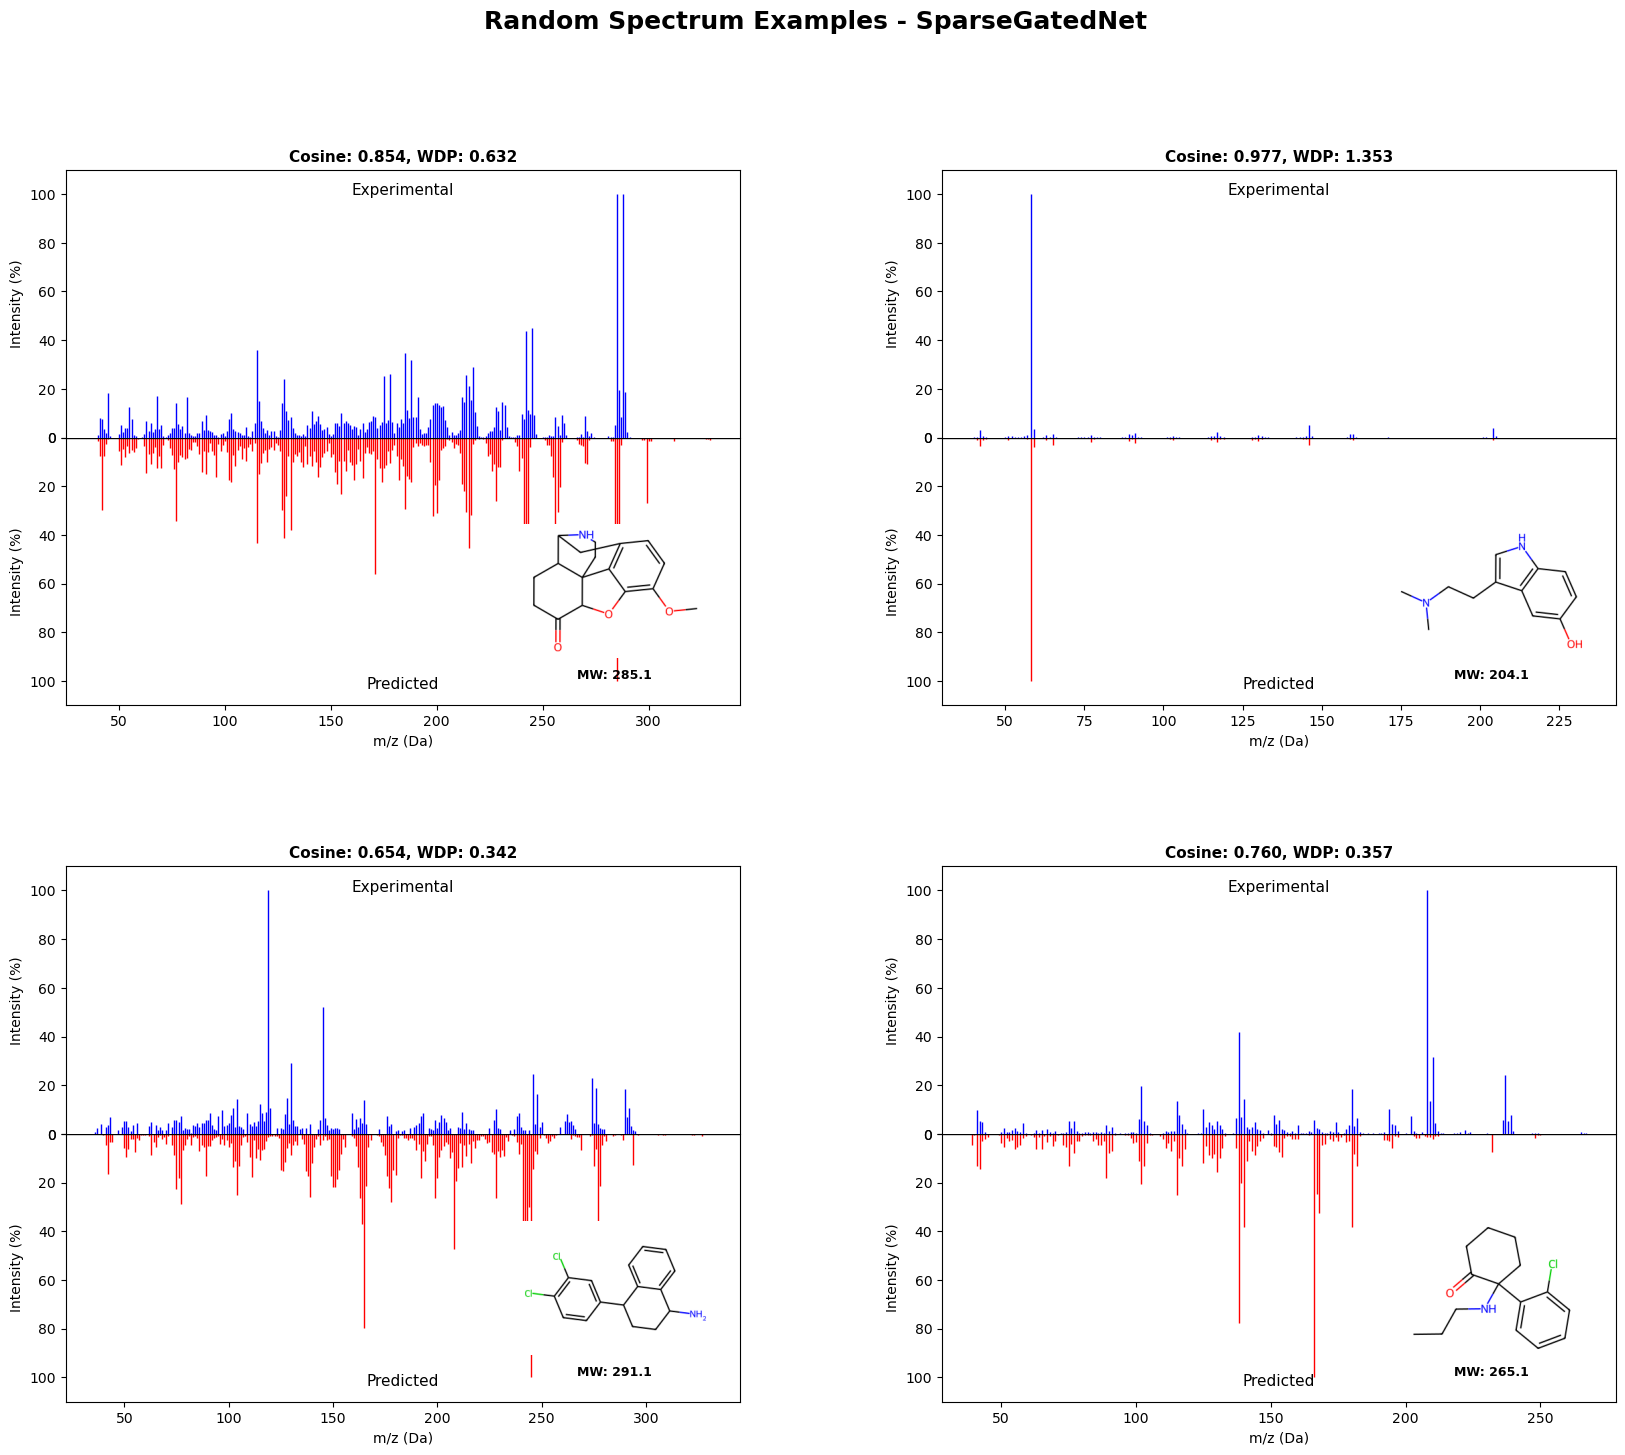


3. Deep Learning Training History


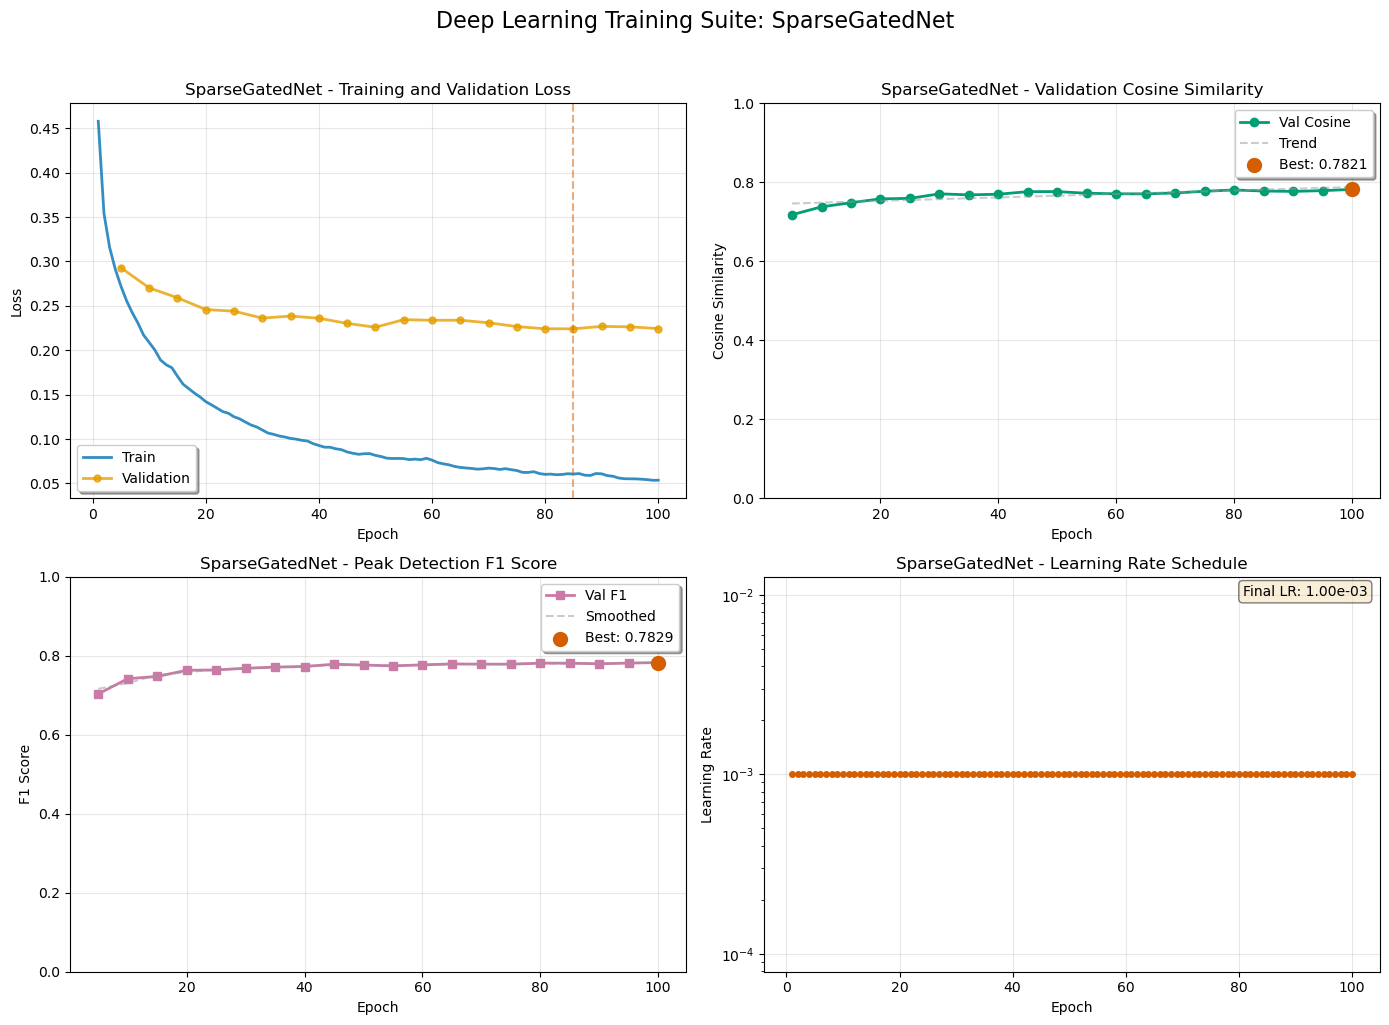

In [12]:
class SparseGatingLayer(nn.Module):
    """Gating layer for sparse predictions"""
    def __init__(self, input_dim, gate_hidden, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        
        self.gate_net = nn.Sequential(
            nn.Linear(input_dim, gate_hidden),
            nn.ReLU(),
            nn.Linear(gate_hidden, input_dim),
            nn.Sigmoid()
        )
        
        self.sparse_path = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.BatchNorm1d(input_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        self.dense_path = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.BatchNorm1d(input_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
    
    def forward(self, x):
        gates = self.gate_net(x) / self.temperature
        sparse_out = self.sparse_path(x)
        dense_out = self.dense_path(x)
        output = gates * dense_out + (1 - gates) * sparse_out
        return output, gates

class SparseGatedNet(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        
        hidden_dims = config['hidden_dims']
        gate_hidden = config['gate_hidden']
        temperature = config['gate_temperature']
        
        self.input_proj = nn.Linear(input_dim, hidden_dims[0])
        self.input_bn = nn.BatchNorm1d(hidden_dims[0])
        
        self.gated_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.gated_layers.append(
                SparseGatingLayer(hidden_dims[i], gate_hidden, temperature)
            )
        
        self.transitions = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.transitions.append(
                nn.Linear(hidden_dims[i], hidden_dims[i+1])
            )
        
        self.output_sparse = nn.Linear(hidden_dims[-1], output_dim)
        self.output_dense = nn.Linear(hidden_dims[-1], output_dim)
        self.output_gate = nn.Sequential(
            nn.Linear(hidden_dims[-1], output_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.input_proj(x)
        x = self.input_bn(x)
        x = F.relu(x)
        
        for gated_layer, transition in zip(self.gated_layers, self.transitions):
            x, _ = gated_layer(x)
            x = transition(x)
            x = F.relu(x)
        
        sparse_pred = F.relu(self.output_sparse(x))
        dense_pred = F.relu(self.output_dense(x))
        output_gates = self.output_gate(x)
        
        output = output_gates * dense_pred + (1 - output_gates) * sparse_pred * 0.1
        
        return output

# Train SparseGatedNet
print("\nTRAINING SPARSEGATEDNET")
print("=" * 60)

# Initialize model
sparsegated_model = SparseGatedNet(input_dim, output_dim, MASTER_CONFIG['sparsegated']).to(DEVICE)
print(f"SparseGatedNet parameters: {sum(p.numel() for p in sparsegated_model.parameters()):,}")

# Train
sparsegated_model, sparsegated_history = train_neural_network(
    sparsegated_model, train_loader, val_loader, MASTER_CONFIG['sparsegated'], "SparseGatedNet"
)

# Evaluate
sparsegated_model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test_scaled).float().to(DEVICE)
    y_test_pred_sparsegated = sparsegated_model(X_test_tensor).cpu().numpy()
    y_test_pred_sparsegated = np.maximum(y_test_pred_sparsegated, 0)

sparsegated_results = evaluate_model(y_test_transformed, y_test_pred_sparsegated, MASTER_CONFIG, "SparseGatedNet")

# Generate standard visualizations
print("\nGenerating Standard Visualizations:")
print("1. Standard 2x2 Diagnostic Plots")
visualize_results(sparsegated_results, "SparseGatedNet")

print("\n2. Random Spectrum Examples")
create_spectrum_grid(sparsegated_results, test_smiles, n_examples=4, model_name="SparseGatedNet")

print("\n3. Deep Learning Training History")
plot_training_history(sparsegated_history, "SparseGatedNet")

## 13. RegionalExpertNet

Mixture-of-experts over m/z regions with soft routing and overlapping slices.

- Regions $\{[s_r,e_r)\}$ with overlap $\delta$
- Router: $\boldsymbol{\pi}=\mathrm{softmax}(\mathrm{Router}(\mathbf{x}))\in\mathbb{R}^{R}$
- Expert $r$ predicts local slice $\hat{\mathbf{y}}^{(r)}$; reconstruction
$$\hat y_b=\sum_{r: b\in[s_r-\delta,e_r+\delta)} \pi_r\; \hat y^{(r)}_{\text{aligned}(b)}.$$

```mermaid
flowchart TD
  X["Input x"] --> R["Router → π"]
  X --> E1["Expert 1 (region)"]
  X --> E2["Expert 2 (region)"]
  X --> Ek["Expert R (region)"]
  E1 --> A1["Align slice"]
  E2 --> A2["Align slice"]
  Ek --> Ak["Align slice"]
  A1 --> Sum
  A2 --> Sum
  Ak --> Sum
  R --> Sum
  Sum --> O["ŷ"]
```
- Global features influence routing decisions
- Each expert focuses on its specialized m/z range


TRAINING REGIONALEXPERTNET
RegionalExpertNet parameters: 22,748,253

Training RegionalExpertNet...


Epoch 5/100: 100%|██████████| 34/34 [00:01<00:00, 32.41it/s, loss=0.2935]


  Val Loss: 0.3221, Cosine: 0.6874, F1: 0.7104


Epoch 10/100: 100%|██████████| 34/34 [00:01<00:00, 26.68it/s, loss=0.2165]


  Val Loss: 0.2851, Cosine: 0.7222, F1: 0.7318


Epoch 15/100: 100%|██████████| 34/34 [00:01<00:00, 25.63it/s, loss=0.1212]


  Val Loss: 0.2503, Cosine: 0.7541, F1: 0.7584


Epoch 20/100: 100%|██████████| 34/34 [00:01<00:00, 25.49it/s, loss=0.1220]


  Val Loss: 0.2410, Cosine: 0.7648, F1: 0.7615


Epoch 25/100: 100%|██████████| 34/34 [00:01<00:00, 21.91it/s, loss=0.1054]


  Val Loss: 0.2439, Cosine: 0.7612, F1: 0.7622


Epoch 30/100: 100%|██████████| 34/34 [00:01<00:00, 20.86it/s, loss=0.0878]


  Val Loss: 0.2373, Cosine: 0.7685, F1: 0.7645


Epoch 35/100: 100%|██████████| 34/34 [00:01<00:00, 27.32it/s, loss=0.0905]


  Val Loss: 0.2306, Cosine: 0.7742, F1: 0.7647


Epoch 40/100: 100%|██████████| 34/34 [00:01<00:00, 23.77it/s, loss=0.0879]


  Val Loss: 0.2329, Cosine: 0.7736, F1: 0.7658


Epoch 45/100: 100%|██████████| 34/34 [00:01<00:00, 24.15it/s, loss=0.0872]


  Val Loss: 0.2289, Cosine: 0.7764, F1: 0.7703


Epoch 50/100: 100%|██████████| 34/34 [00:02<00:00, 16.93it/s, loss=0.0829]


  Val Loss: 0.2294, Cosine: 0.7755, F1: 0.7701


Epoch 55/100: 100%|██████████| 34/34 [00:02<00:00, 15.45it/s, loss=0.0786]


  Val Loss: 0.2292, Cosine: 0.7763, F1: 0.7719


Epoch 60/100: 100%|██████████| 34/34 [00:02<00:00, 15.10it/s, loss=0.0622]


  Val Loss: 0.2315, Cosine: 0.7746, F1: 0.7704


Epoch 65/100: 100%|██████████| 34/34 [00:01<00:00, 17.36it/s, loss=0.0522]


  Val Loss: 0.2306, Cosine: 0.7756, F1: 0.7730


Epoch 70/100: 100%|██████████| 34/34 [00:01<00:00, 26.16it/s, loss=0.0540]


  Val Loss: 0.2289, Cosine: 0.7776, F1: 0.7744


Epoch 75/100: 100%|██████████| 34/34 [00:01<00:00, 21.96it/s, loss=0.0609]


  Val Loss: 0.2293, Cosine: 0.7757, F1: 0.7749


Epoch 80/100: 100%|██████████| 34/34 [00:02<00:00, 15.66it/s, loss=0.0672]


  Val Loss: 0.2273, Cosine: 0.7782, F1: 0.7747


Epoch 85/100: 100%|██████████| 34/34 [00:01<00:00, 18.71it/s, loss=0.0712]


  Val Loss: 0.2270, Cosine: 0.7773, F1: 0.7743


Epoch 90/100: 100%|██████████| 34/34 [00:01<00:00, 27.13it/s, loss=0.0602]


  Val Loss: 0.2301, Cosine: 0.7764, F1: 0.7756


Epoch 95/100: 100%|██████████| 34/34 [00:01<00:00, 25.72it/s, loss=0.0499]


  Val Loss: 0.2262, Cosine: 0.7792, F1: 0.7770


Epoch 100/100: 100%|██████████| 34/34 [00:01<00:00, 26.64it/s, loss=0.0682]


  Val Loss: 0.2287, Cosine: 0.7768, F1: 0.7766

Training complete. Best validation cosine: 0.7792

RegionalExpertNet Performance:
  Cosine Similarity: 0.7622
  MSE: 0.0053
  R2 Score: 0.2382
  MAE: 0.0240
  Median AE: 0.0073
  Max Error: 1.5859
  Explained Variance: 0.2489

Generating Standard Visualizations:
1. Standard 2x2 Diagnostic Plots


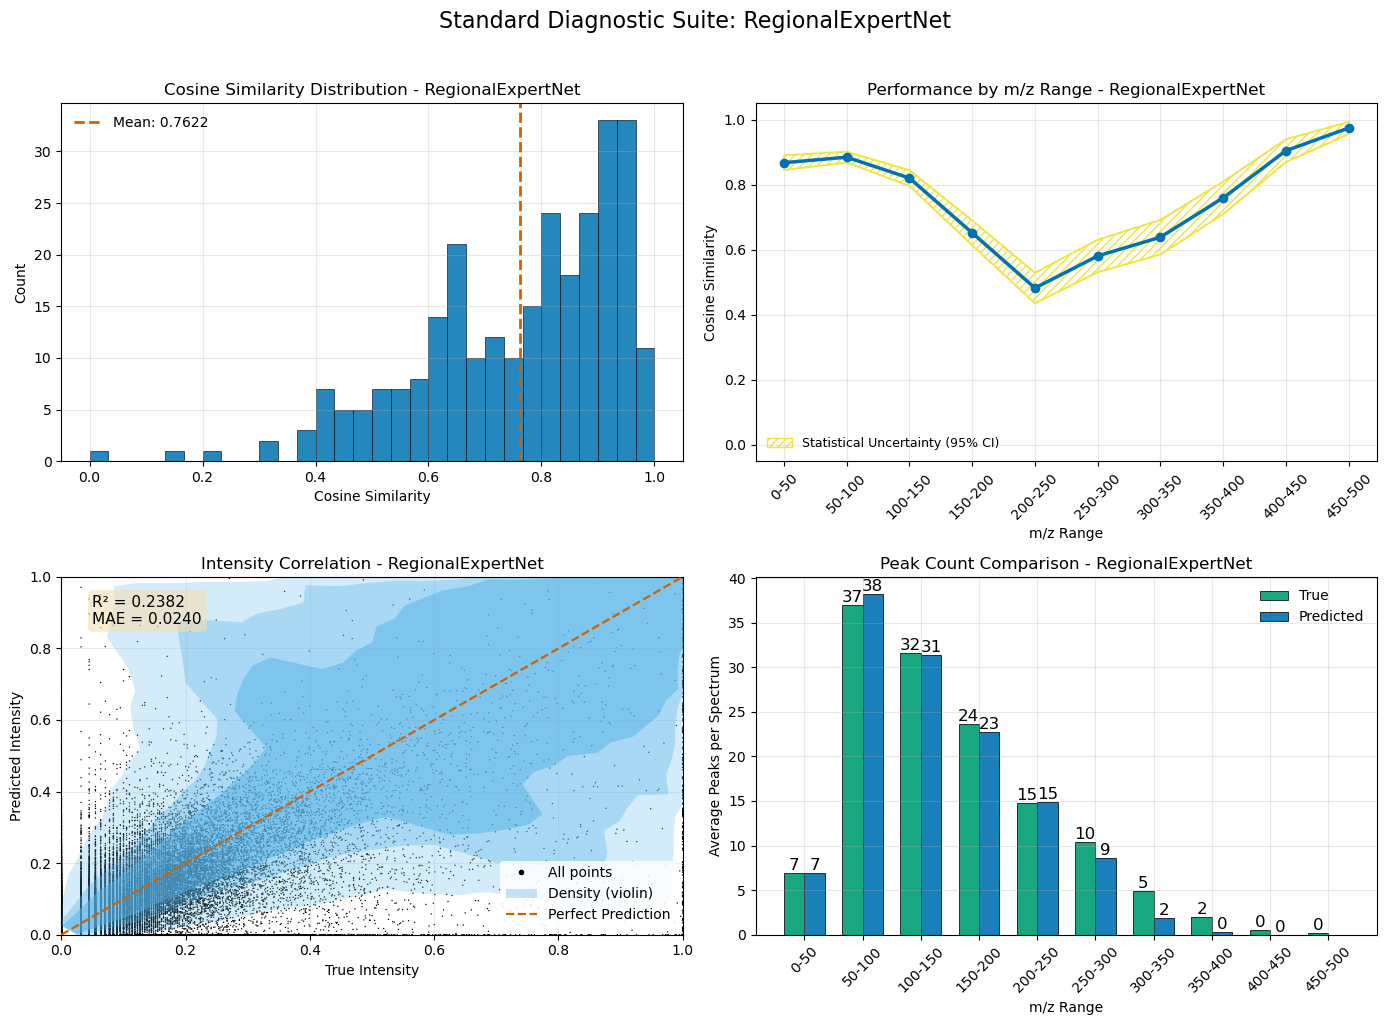


2. Random Spectrum Examples

Selected random examples:
  1. Index 22: Cosine=0.9345, WDP=0.8362
  2. Index 86: Cosine=0.8767, WDP=0.7636
  3. Index 248: Cosine=0.9341, WDP=0.7957
  4. Index 202: Cosine=0.6598, WDP=0.3588


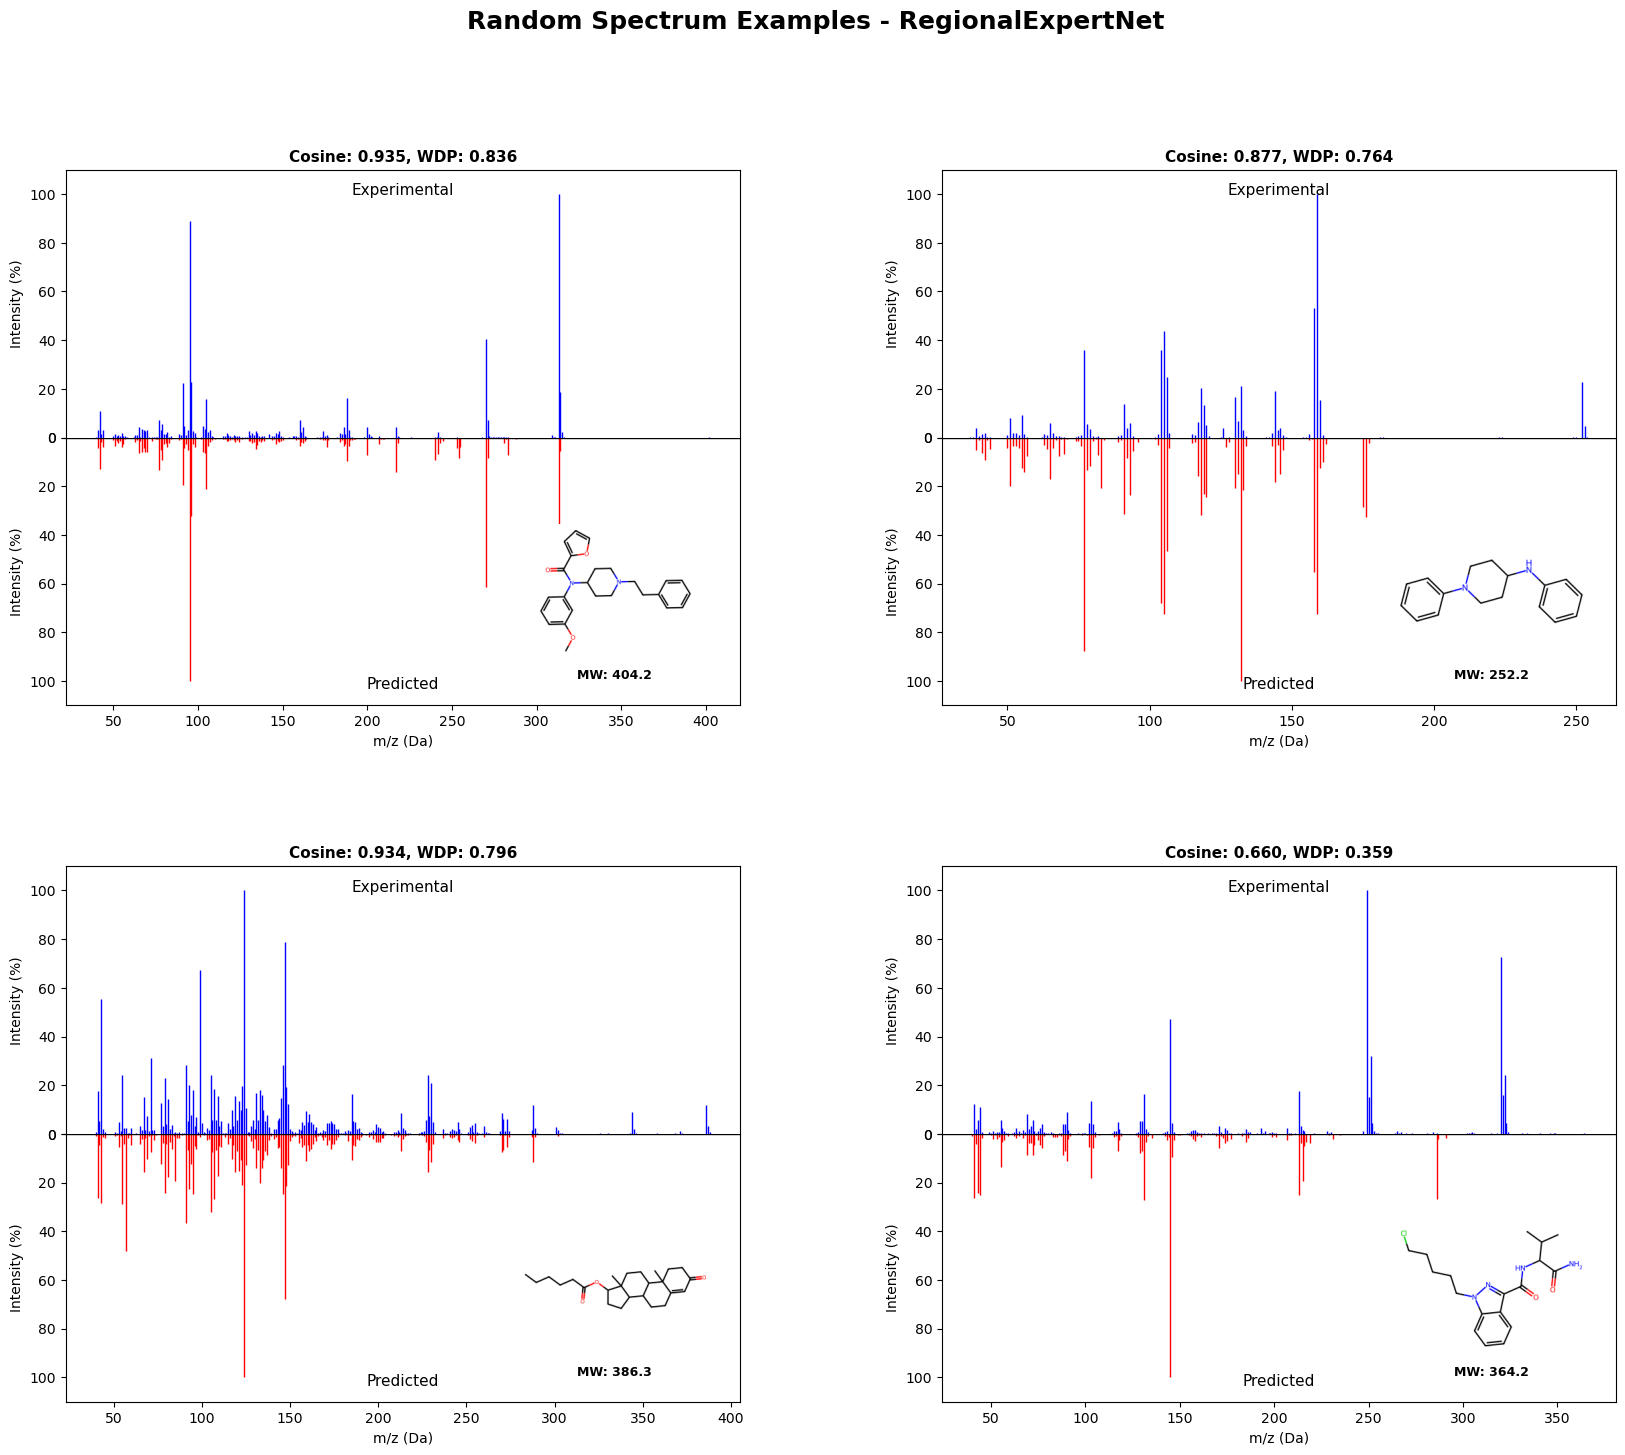


3. Deep Learning Training History


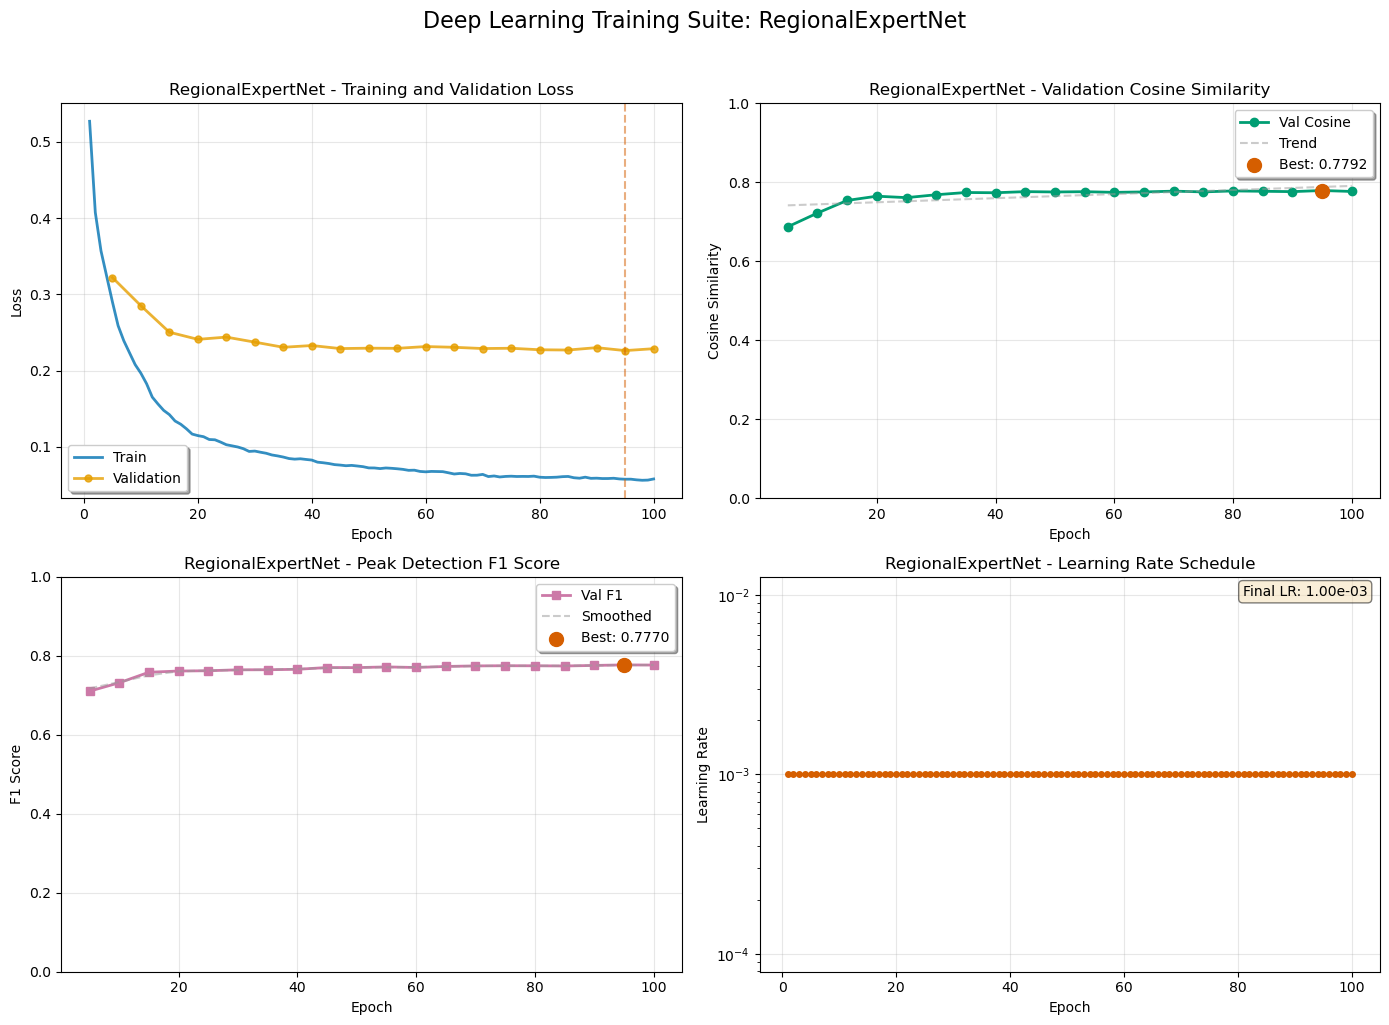

In [13]:
class RegionalExpert(nn.Module):
    """Expert network for a specific m/z region"""
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        
        layers = []
        dims = [input_dim] + hidden_dims
        
        for i in range(len(hidden_dims)):
            layers.extend([
                nn.Linear(dims[i], dims[i+1]),
                nn.BatchNorm1d(dims[i+1]),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
        
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        layers.append(nn.ReLU())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class RegionalExpertNet(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        
        self.expert_regions = config['expert_regions']
        expert_hidden = config['expert_hidden']
        router_hidden = config['router_hidden']
        self.overlap_bins = config['overlap_bins']
        
        # Create experts
        self.experts = nn.ModuleList()
        for start, end in self.expert_regions:
            expert_output_dim = end - start + 2 * self.overlap_bins
            self.experts.append(
                RegionalExpert(input_dim, expert_output_dim, expert_hidden)
            )
        
        # Router network
        self.router = nn.Sequential(
            nn.Linear(input_dim, router_hidden),
            nn.ReLU(),
            nn.Linear(router_hidden, len(self.expert_regions)),
            nn.Softmax(dim=1)
        )
        
        # Global features
        self.global_features = nn.Sequential(
            nn.Linear(input_dim, router_hidden),
            nn.BatchNorm1d(router_hidden),
            nn.ReLU()
        )
    
    def forward(self, x):
        routing_weights = self.router(x)
        global_feat = self.global_features(x)
        
        output = torch.zeros(x.shape[0], 500).to(x.device)  # Fixed output size
        
        for i, ((start, end), expert) in enumerate(zip(self.expert_regions, self.experts)):
            expert_pred = expert(x)
            
            actual_start = max(0, start - self.overlap_bins)
            actual_end = min(500, end + self.overlap_bins)
            
            region_size = actual_end - actual_start
            if expert_pred.shape[1] >= region_size:
                weighted_pred = expert_pred[:, :region_size] * routing_weights[:, i:i+1]
                output[:, actual_start:actual_end] += weighted_pred
        
        return output

# Train RegionalExpertNet
print("\nTRAINING REGIONALEXPERTNET")
print("=" * 60)

# Initialize model
regional_model = RegionalExpertNet(input_dim, output_dim, MASTER_CONFIG['regional']).to(DEVICE)
print(f"RegionalExpertNet parameters: {sum(p.numel() for p in regional_model.parameters()):,}")

# Train
regional_model, regional_history = train_neural_network(
    regional_model, train_loader, val_loader, MASTER_CONFIG['regional'], "RegionalExpertNet"
)

# Evaluate
regional_model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test_scaled).float().to(DEVICE)
    y_test_pred_regional = regional_model(X_test_tensor).cpu().numpy()
    y_test_pred_regional = np.maximum(y_test_pred_regional, 0)

regional_results = evaluate_model(y_test_transformed, y_test_pred_regional, MASTER_CONFIG, "RegionalExpertNet")

# Generate standard visualizations
print("\nGenerating Standard Visualizations:")
print("1. Standard 2x2 Diagnostic Plots")
visualize_results(regional_results, "RegionalExpertNet")

print("\n2. Random Spectrum Examples")
create_spectrum_grid(regional_results, test_smiles, n_examples=4, model_name="RegionalExpertNet")

print("\n3. Deep Learning Training History")
plot_training_history(regional_history, "RegionalExpertNet")

## 14. Ensemble Methods

Combine predictions from all models using weighted ensemble approaches.

### Ensemble Theory:

Ensemble methods leverage the principle that combining diverse models often yields better performance than individual models.

### 1. Simple Weighted Ensemble:

Finds global weights that optimize cosine similarity across all models:

$$\hat{y}_{ensemble} = \sum_{m=1}^{M} w_m \cdot \hat{y}_m$$

Subject to:
- $\sum_{m=1}^{M} w_m = 1$ (weights sum to 1)
- $w_m \geq 0$ (non-negative weights)

**Optimization problem:**
$$\min_{w} -\text{cosine\_similarity}(y_{true}, \sum_{m} w_m \cdot \hat{y}_m)$$

### 2. Bin-by-bin Optimization:

Optimizes weights independently for each m/z bin:

$$\hat{y}_{ensemble,j} = \sum_{m=1}^{M} w_{m,j} \cdot \hat{y}_{m,j}$$

Where $w_{m,j}$ is the weight for model $m$ at m/z bin $j$.

**Advantages:**
- Captures model strengths at different m/z ranges
- More flexible than global weighting
- Can improve performance when models have complementary strengths

### Models in Ensemble:

All six models contribute to the final ensemble:
- **Random Forest**: Non-linear feature interactions
- **K-Nearest Neighbors**: Local predictions with optimized Hamming distance
- **ModularNet**: Attention-based module fusion
- **HierarchicalPredictionNet**: Two-stage presence and intensity prediction
- **SparseGatedNet**: Specialized for extreme sparsity handling
- **RegionalExpertNet**: m/z region-specific experts

### Optimization Method:

Uses Sequential Least Squares Programming (SLSQP) to solve the constrained optimization problem.
- Optimizes on test data to find best weights
- Ensures weights are non-negative and sum to 1
- Maximizes cosine similarity between ensemble prediction and ground truth


ENSEMBLE MODEL ANALYSIS

INDIVIDUAL MODEL PERFORMANCE:
  Random Forest: Cosine Similarity = 0.783741
  KNN: Cosine Similarity = 0.732502
  ModularNet: Cosine Similarity = 0.769062
  HierarchicalPredictionNet: Cosine Similarity = 0.776977
  SparseGatedNet: Cosine Similarity = 0.767443
  RegionalExpertNet: Cosine Similarity = 0.762164

SIMPLE WEIGHTED ENSEMBLE:
  Cosine Similarity: 0.803672

  Weights:
    Random Forest: 0.4531
    KNN: 0.0000
    ModularNet: 0.1193
    HierarchicalPredictionNet: 0.1500
    SparseGatedNet: 0.1691
    RegionalExpertNet: 0.1085

BIN-BY-BIN ENSEMBLE:

Optimizing bin-by-bin weights (500 bins)...
  Processing bin 0/500
  Processing bin 100/500
  Processing bin 200/500
  Processing bin 300/500
  Processing bin 400/500
  Cosine Similarity: 0.816379

  Average Bin Weights:
    Random Forest: 0.3841
    KNN: 0.1089
    ModularNet: 0.1189
    HierarchicalPredictionNet: 0.1313
    SparseGatedNet: 0.1292
    RegionalExpertNet: 0.1276

PERFORMANCE SUMMARY:
Method   

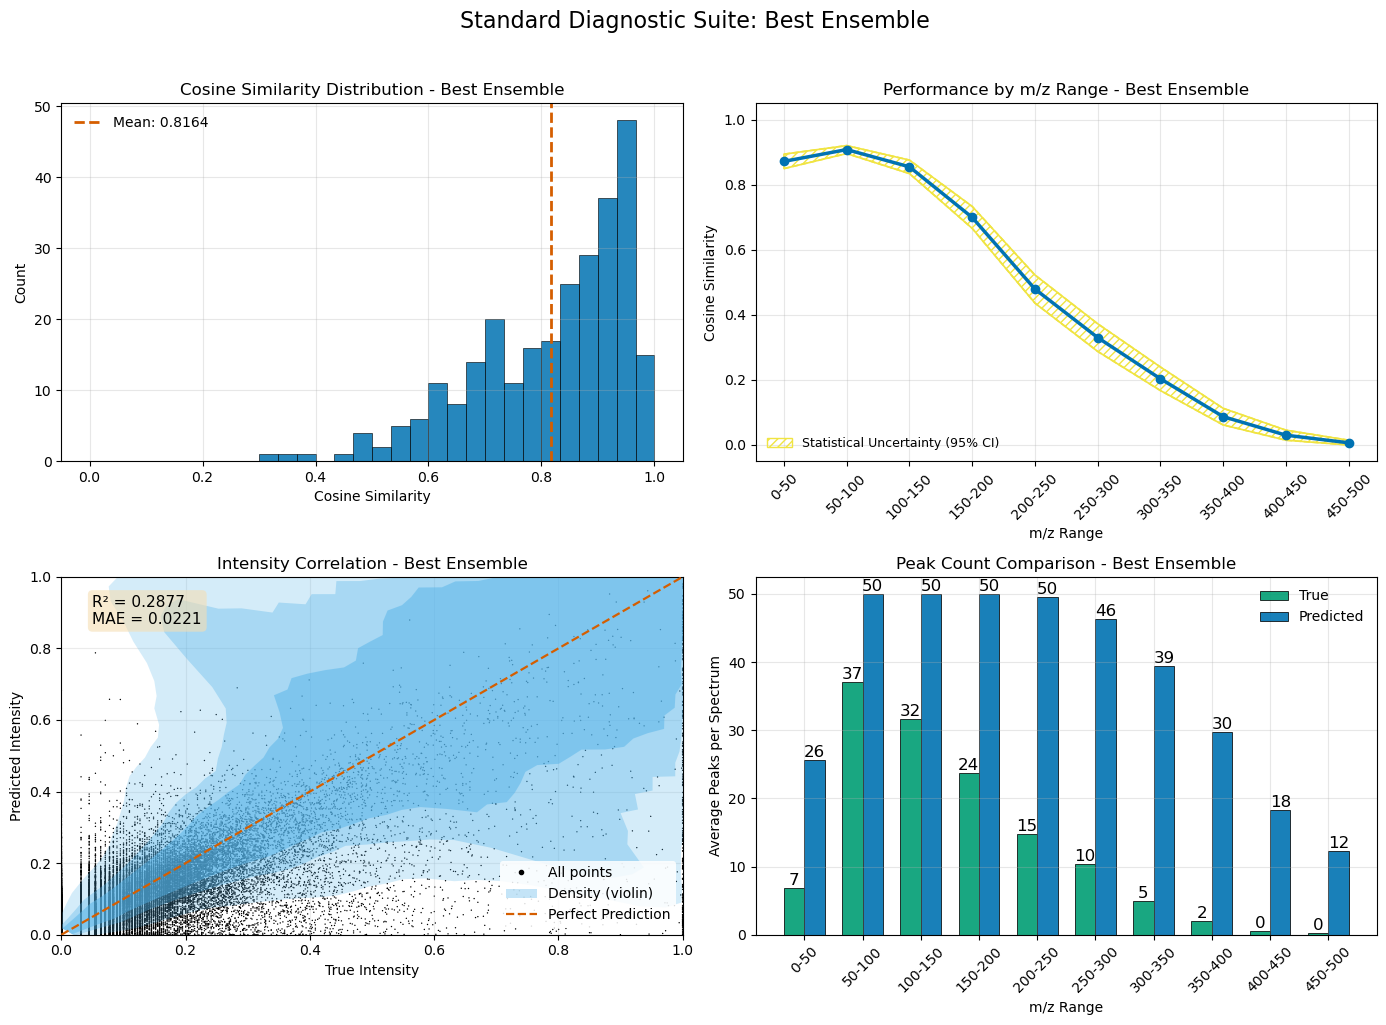


Saving ensemble results...
Results saved to ../models/ensemble_results.pkl
All predictions saved to ../models/all_model_predictions.pkl

ENSEMBLE ANALYSIS COMPLETE
Final Best Model: Bin-by-bin Ensemble
Final Cosine Similarity: 0.816379


In [14]:
print("\nENSEMBLE MODEL ANALYSIS")
print("=" * 60)

# Collect all predictions
all_predictions = {
    'Random Forest': y_test_pred_rf,
    'KNN': y_test_pred_knn,
    'ModularNet': y_test_pred_modularnet,
    'HierarchicalPredictionNet': y_test_pred_hierarchical,
    'SparseGatedNet': y_test_pred_sparsegated,
    'RegionalExpertNet': y_test_pred_regional
}

# Individual model performance
print("\nINDIVIDUAL MODEL PERFORMANCE:")
individual_results = {}
for model_name, predictions in all_predictions.items():
    cos_sim, _ = cosine_similarity_matrix(y_test_transformed, predictions)
    individual_results[model_name] = cos_sim
    print(f"  {model_name}: Cosine Similarity = {cos_sim:.6f}")

def simple_weighted_ensemble(predictions_dict, y_true):
    """Simple weighted ensemble optimization."""
    model_names = list(predictions_dict.keys())
    n_models = len(model_names)
    
    def objective(weights):
        weights = np.abs(weights)
        weights = weights / np.sum(weights)
        
        ensemble_pred = np.zeros_like(y_true)
        for i, model in enumerate(model_names):
            ensemble_pred += weights[i] * predictions_dict[model]
        
        cos_sim, _ = cosine_similarity_matrix(y_true, ensemble_pred)
        return -cos_sim
    
    # Optimize weights
    result = minimize(objective, np.ones(n_models) / n_models,
                     method='SLSQP',
                     bounds=[(0, 1)] * n_models,
                     constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    
    optimal_weights = result.x
    
    # Apply to predictions
    ensemble_pred = np.zeros_like(y_true)
    for i, model in enumerate(model_names):
        ensemble_pred += optimal_weights[i] * predictions_dict[model]
    
    return ensemble_pred, optimal_weights, model_names

def bin_by_bin_optimization(predictions_dict, y_true):
    """Bin-by-bin weight optimization."""
    model_names = list(predictions_dict.keys())
    n_models = len(model_names)
    n_bins = y_true.shape[1]
    
    optimal_weights = np.zeros((n_bins, n_models))
    
    print(f"\nOptimizing bin-by-bin weights ({n_bins} bins)...")
    
    # Optimize weights for each bin
    for bin_idx in range(n_bins):
        if bin_idx % 100 == 0:
            print(f"  Processing bin {bin_idx}/{n_bins}")
            
        bin_preds = [predictions_dict[model][:, bin_idx] for model in model_names]
        bin_true = y_true[:, bin_idx]
        
        if np.sum(bin_true) == 0:
            optimal_weights[bin_idx] = [1/n_models] * n_models
            continue
        
        def objective(weights):
            weights = np.abs(weights)
            weights = weights / np.sum(weights)
            
            ensemble_pred = sum(w * pred for w, pred in zip(weights, bin_preds))
            
            if np.sum(ensemble_pred) > 0 and np.sum(bin_true) > 0:
                cos_sim = 1 - cosine(bin_true, ensemble_pred)
                return -cos_sim
            else:
                return mean_squared_error(bin_true, ensemble_pred)
        
        result = minimize(objective, [1/n_models] * n_models, 
                         method='SLSQP',
                         bounds=[(0, 1)] * n_models,
                         constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        
        optimal_weights[bin_idx] = result.x
    
    # Apply to predictions
    ensemble_pred = np.zeros_like(y_true)
    for bin_idx in range(n_bins):
        weights = optimal_weights[bin_idx]
        for i, model in enumerate(model_names):
            ensemble_pred[:, bin_idx] += weights[i] * predictions_dict[model][:, bin_idx]
    
    return ensemble_pred, optimal_weights, model_names

# Simple weighted ensemble
print("\nSIMPLE WEIGHTED ENSEMBLE:")
simple_pred, simple_weights, model_names = simple_weighted_ensemble(all_predictions, y_test_transformed)
simple_cos, _ = cosine_similarity_matrix(y_test_transformed, simple_pred)
print(f"  Cosine Similarity: {simple_cos:.6f}")
print(f"\n  Weights:")
for model, weight in zip(model_names, simple_weights):
    print(f"    {model}: {weight:.4f}")

# Bin-by-bin optimization
print("\nBIN-BY-BIN ENSEMBLE:")
binwise_pred, binwise_weights, model_names = bin_by_bin_optimization(all_predictions, y_test_transformed)
binwise_cos, _ = cosine_similarity_matrix(y_test_transformed, binwise_pred)
print(f"  Cosine Similarity: {binwise_cos:.6f}")

# Weight analysis
mean_weights = np.mean(binwise_weights, axis=0)
print(f"\n  Average Bin Weights:")
for model, weight in zip(model_names, mean_weights):
    print(f"    {model}: {weight:.4f}")

# Performance summary
print("\nPERFORMANCE SUMMARY:")
print("=" * 50)
methods = list(individual_results.keys()) + ['Simple Weighted Ensemble', 'Bin-by-bin Ensemble']
cosine_scores = list(individual_results.values()) + [simple_cos, binwise_cos]

print(f"{'Method':<35} {'Cosine Sim':<12} {'Rank':<6}")
print("-" * 53)

# Sort by cosine similarity
sorted_results = sorted(zip(methods, cosine_scores), key=lambda x: x[1], reverse=True)
for rank, (method, score) in enumerate(sorted_results, 1):
    print(f"{method:<35} {score:<12.6f} #{rank}")

best_individual = max(individual_results.values())
best_ensemble = max(simple_cos, binwise_cos)
improvement = best_ensemble - best_individual

print(f"\nIMPROVEMENT ANALYSIS:")
print(f"  Best Individual Model: {best_individual:.6f}")
print(f"  Best Ensemble Method: {best_ensemble:.6f}")
print(f"  Absolute Improvement: +{improvement:.6f}")
print(f"  Relative Improvement: +{improvement/best_individual*100:.2f}%")

# Visualize ensemble results
ensemble_results = {
    'cosine': best_ensemble,
    'y_pred': binwise_pred if binwise_cos > simple_cos else simple_pred,
    'y_true': y_test_transformed,
    'individual_cos_sims': cosine_similarity_matrix(y_test_transformed, binwise_pred if binwise_cos > simple_cos else simple_pred)[1],
    'mz_range_sims': cosine_similarity_by_mz_range(y_test_transformed, binwise_pred if binwise_cos > simple_cos else simple_pred, MASTER_CONFIG),
    'mse': mean_squared_error(y_test_transformed, binwise_pred if binwise_cos > simple_cos else simple_pred),
    'r2': r2_score(y_test_transformed, binwise_pred if binwise_cos > simple_cos else simple_pred),
    'mae': mean_absolute_error(y_test_transformed, binwise_pred if binwise_cos > simple_cos else simple_pred)
}

print("\nVisualizing best ensemble results...")
visualize_results(ensemble_results, "Best Ensemble")

# Save ensemble results
print("\nSaving ensemble results...")
ensemble_data = {
    'individual_results': individual_results,
    'simple_weighted': {
        'weights': dict(zip(model_names, simple_weights)),
        'cosine': simple_cos,
        'predictions': simple_pred
    },
    'bin_by_bin': {
        'weights': binwise_weights,
        'mean_weights': dict(zip(model_names, mean_weights)),
        'cosine': binwise_cos,
        'predictions': binwise_pred
    },
    'summary': sorted_results,
    'improvement': {
        'absolute': improvement,
        'relative_percent': improvement/best_individual*100
    }
}

ensemble_path = os.path.join(MASTER_CONFIG['paths']['models_dir'], 'ensemble_results.pkl')
with open(ensemble_path, 'wb') as f:
    pickle.dump(ensemble_data, f)
print(f"Results saved to {ensemble_path}")

# Save all individual model predictions
all_predictions_path = os.path.join(MASTER_CONFIG['paths']['models_dir'], 'all_model_predictions.pkl')
with open(all_predictions_path, 'wb') as f:
    pickle.dump({
        'predictions': all_predictions,
        'y_true': y_test_transformed,
        'test_smiles': test_smiles
    }, f)
print(f"All predictions saved to {all_predictions_path}")

print("\nENSEMBLE ANALYSIS COMPLETE")
print(f"Final Best Model: {'Bin-by-bin Ensemble' if binwise_cos > simple_cos else 'Simple Weighted Ensemble'}")
print(f"Final Cosine Similarity: {best_ensemble:.6f}")

## 15. Model Persistence and Deployment

Save the best performing model configuration for production use. Based on the evaluation results, we save:

1. **Best Model Components**:
   - If ensemble: All constituent models + ensemble weights
   - If individual: Single model + preprocessing pipeline
   
2. **Saved Artifacts**:
   - Trained models (scikit-learn and PyTorch state dicts)
   - Feature scaler
   - Ensemble weights (if applicable)
   - Configuration parameters
   - Model metadata and performance metrics

3. **Loading Interface**:
   The saved model can be loaded with a simple interface:
   ```python
   model_package = load_best_model('../data/models/best_model.pkl')
   predictions = model_package.predict(X_new)

In [15]:
print("\nSAVING BEST MODEL FOR DEPLOYMENT")
print("=" * 60)

import os
import pickle
import torch
import json
from datetime import datetime
import copy

# Determine best model
all_scores = {
    'Random Forest': rf_results['cosine'],
    'KNN': knn_results['cosine'],
    'ModularNet': modularnet_results['cosine'],
    'HierarchicalPredictionNet': hierarchical_results['cosine'],
    'SparseGatedNet': sparsegated_results['cosine'],
    'RegionalExpertNet': regional_results['cosine'],
    'Simple Weighted Ensemble': simple_cos,
    'Bin-by-bin Ensemble': binwise_cos
}

best_model_name = max(all_scores, key=all_scores.get)
best_score = all_scores[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Cosine Similarity: {best_score:.6f}")

# Create models directory
models_dir = '../data/models'
os.makedirs(models_dir, exist_ok=True)

class BestModelPredictor:
    """Unified interface for the best model prediction."""
    
    def __init__(self, model_type, components, config):
        self.model_type = model_type
        self.components = components
        self.config = config
        self.device = torch.device("cpu")  # Default to CPU for deployment
        
    def predict(self, X):
        """Predict mass spectra from features."""
        # Scale features
        X_scaled = self.components['scaler'].transform(X)
        
        if self.model_type == 'Bin-by-bin Ensemble':
            return self._predict_binwise_ensemble(X_scaled)
        elif self.model_type == 'Simple Weighted Ensemble':
            return self._predict_simple_ensemble(X_scaled)
        elif self.model_type in ['Random Forest', 'KNN']:
            return self._predict_sklearn(X_scaled)
        else:
            return self._predict_neural(X_scaled)
    
    def _predict_binwise_ensemble(self, X_scaled):
        """Predict using bin-by-bin weighted ensemble."""
        predictions = {}
        
        # Get predictions from all models
        for name, model in self.components['models'].items():
            if name in ['Random Forest', 'KNN']:
                predictions[name] = model.predict(X_scaled)
            else:
                # Neural network
                model.eval()
                with torch.no_grad():
                    X_tensor = torch.from_numpy(X_scaled).float().to(self.device)
                    pred = model(X_tensor).cpu().numpy()
                    predictions[name] = pred
        
        # Apply bin-by-bin weights
        weights = self.components['binwise_weights']
        model_names = self.components['model_names']
        n_samples = X_scaled.shape[0]
        n_bins = weights.shape[0]
        
        ensemble_pred = np.zeros((n_samples, n_bins))
        for bin_idx in range(n_bins):
            bin_weights = weights[bin_idx]
            for i, model_name in enumerate(model_names):
                ensemble_pred[:, bin_idx] += bin_weights[i] * predictions[model_name][:, bin_idx]
        
        # Apply inverse transformation if needed
        if self.config.get('transform_sqrt', False):
            ensemble_pred = ensemble_pred ** 2
            
        return np.maximum(ensemble_pred, 0)
    
    def _predict_simple_ensemble(self, X_scaled):
        """Predict using simple weighted ensemble."""
        predictions = {}
        
        # Get predictions from all models
        for name, model in self.components['models'].items():
            if name in ['Random Forest', 'KNN']:
                predictions[name] = model.predict(X_scaled)
            else:
                # Neural network
                model.eval()
                with torch.no_grad():
                    X_tensor = torch.from_numpy(X_scaled).float().to(self.device)
                    pred = model(X_tensor).cpu().numpy()
                    predictions[name] = pred
        
        # Apply weights
        weights = self.components['simple_weights']
        model_names = self.components['model_names']
        
        ensemble_pred = np.zeros_like(predictions[model_names[0]])
        for i, model_name in enumerate(model_names):
            ensemble_pred += weights[i] * predictions[model_name]
        
        # Apply inverse transformation if needed
        if self.config.get('transform_sqrt', False):
            ensemble_pred = ensemble_pred ** 2
            
        return np.maximum(ensemble_pred, 0)
    
    def _predict_sklearn(self, X_scaled):
        """Predict using scikit-learn model."""
        pred = self.components['model'].predict(X_scaled)
        
        # Apply inverse transformation if needed
        if self.config.get('transform_sqrt', False):
            pred = pred ** 2
            
        return np.maximum(pred, 0)
    
    def _predict_neural(self, X_scaled):
        """Predict using neural network."""
        model = self.components['model']
        model.eval()
        
        with torch.no_grad():
            X_tensor = torch.from_numpy(X_scaled).float().to(self.device)
            pred = model(X_tensor).cpu().numpy()
        
        # Apply inverse transformation if needed
        if self.config.get('transform_sqrt', False):
            pred = pred ** 2
            
        return np.maximum(pred, 0)
    
    def to(self, device):
        """Move neural network models to specified device."""
        self.device = device
        if self.model_type not in ['Random Forest', 'KNN']:
            if 'Ensemble' in self.model_type:
                for name, model in self.components['models'].items():
                    if name not in ['Random Forest', 'KNN']:
                        self.components['models'][name] = model.to(device)
            else:
                self.components['model'] = self.components['model'].to(device)
        return self

# Prepare components based on best model
if best_model_name == 'Bin-by-bin Ensemble':
    print("\nPreparing Bin-by-bin Ensemble for saving...")
    
    # Collect all models
    all_models = {
        'Random Forest': rf_model,
        'KNN': knn_model,
        'ModularNet': modularnet_model.cpu(),
        'HierarchicalPredictionNet': hierarchical_model.cpu(),
        'SparseGatedNet': sparsegated_model.cpu(),
        'RegionalExpertNet': regional_model.cpu()
    }
    
    components = {
        'models': all_models,
        'scaler': scaler,
        'binwise_weights': binwise_weights,
        'model_names': model_names,
        'performance': {
            'cosine_similarity': binwise_cos,
            'individual_scores': individual_results
        }
    }
    
elif best_model_name == 'Simple Weighted Ensemble':
    print("\nPreparing Simple Weighted Ensemble for saving...")
    
    # Collect all models
    all_models = {
        'Random Forest': rf_model,
        'KNN': knn_model,
        'ModularNet': modularnet_model.cpu(),
        'HierarchicalPredictionNet': hierarchical_model.cpu(),
        'SparseGatedNet': sparsegated_model.cpu(),
        'RegionalExpertNet': regional_model.cpu()
    }
    
    components = {
        'models': all_models,
        'scaler': scaler,
        'simple_weights': simple_weights,
        'model_names': model_names,
        'performance': {
            'cosine_similarity': simple_cos,
            'individual_scores': individual_results
        }
    }
    
elif best_model_name == 'Random Forest':
    print("\nPreparing Random Forest for saving...")
    components = {
        'model': rf_model,
        'scaler': scaler,
        'performance': {'cosine_similarity': rf_results['cosine']}
    }
    
elif best_model_name == 'KNN':
    print("\nPreparing KNN for saving...")
    components = {
        'model': knn_model,
        'scaler': scaler,
        'performance': {'cosine_similarity': knn_results['cosine']}
    }
    
else:
    # Neural network models
    print(f"\nPreparing {best_model_name} for saving...")
    
    model_map = {
        'ModularNet': modularnet_model,
        'HierarchicalPredictionNet': hierarchical_model,
        'SparseGatedNet': sparsegated_model,
        'RegionalExpertNet': regional_model
    }
    
    components = {
        'model': model_map[best_model_name].cpu(),
        'scaler': scaler,
        'performance': {'cosine_similarity': all_scores[best_model_name]}
    }

# Create model package
model_package = BestModelPredictor(
    model_type=best_model_name,
    components=components,
    config=MASTER_CONFIG['data']
)

# Create a clean copy of MASTER_CONFIG without lambda functions for serialization
def clean_config_for_pickle(config):
    """Remove non-serializable items from config."""
    clean = copy.deepcopy(config)
    # Remove lambda functions
    if 'paths' in clean and 'data_subdir' in clean['paths']:
        # Replace lambda with the actual value
        use_selected = clean['paths'].get('use_selected_data', False)
        clean['paths']['data_subdir'] = 'selected' if use_selected else 'full_featurised'
    return clean

# Clean the config for serialization
clean_master_config = clean_config_for_pickle(MASTER_CONFIG)

# Save the model package
model_metadata = {
    'model_type': best_model_name,
    'cosine_similarity': best_score,
    'training_date': datetime.now().isoformat(),
    'input_dim': input_dim,
    'output_dim': output_dim,
    'config': clean_master_config,  # Use cleaned config
    'all_scores': all_scores
}

# Save main model file
best_model_path = os.path.join(models_dir, 'best_model.pkl')
print(f"\nSaving best model to {best_model_path}...")
with open(best_model_path, 'wb') as f:
    pickle.dump({
        'predictor': model_package,
        'metadata': model_metadata
    }, f)

# Save individual neural network state dicts for PyTorch loading
if 'Ensemble' in best_model_name or best_model_name not in ['Random Forest', 'KNN']:
    nn_models_dir = os.path.join(models_dir, 'neural_networks')
    os.makedirs(nn_models_dir, exist_ok=True)
    
    if 'Ensemble' in best_model_name:
        # Save all neural network models
        for name in ['ModularNet', 'HierarchicalPredictionNet', 'SparseGatedNet', 'RegionalExpertNet']:
            model = all_models[name]
            # Get the correct config key
            config_key = name.lower().replace('predictionnet', '').replace('net', 'net')
            if config_key == 'modularnet':
                config_key = 'modularnet'
            elif config_key == 'hierarchical':
                config_key = 'hierarchical'
            elif config_key == 'sparsegatednet':
                config_key = 'sparsegated'
            elif config_key == 'regionalexpertnet':
                config_key = 'regional'
            
            torch.save({
                'model_state_dict': model.state_dict(),
                'config': clean_master_config.get(config_key, {}),
                'input_dim': input_dim,
                'output_dim': output_dim
            }, os.path.join(nn_models_dir, f'{name.lower()}.pt'))
    else:
        # Save single neural network
        config_key = best_model_name.lower().replace('predictionnet', '').replace('net', 'net')
        if config_key == 'modularnet':
            config_key = 'modularnet'
        elif config_key == 'hierarchical':
            config_key = 'hierarchical'
        elif config_key == 'sparsegatednet':
            config_key = 'sparsegated'
        elif config_key == 'regionalexpertnet':
            config_key = 'regional'
            
        torch.save({
            'model_state_dict': components['model'].state_dict(),
            'config': clean_master_config.get(config_key, {}),
            'input_dim': input_dim,
            'output_dim': output_dim
        }, os.path.join(nn_models_dir, f'{best_model_name.lower()}.pt'))

# Save metadata as JSON for easy inspection
metadata_path = os.path.join(models_dir, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    # Convert numpy values to Python types for JSON serialization
    json_metadata = {
        'model_type': best_model_name,
        'cosine_similarity': float(best_score),
        'training_date': model_metadata['training_date'],
        'input_dim': int(input_dim),
        'output_dim': int(output_dim),
        'all_scores': {k: float(v) for k, v in all_scores.items()}
    }
    json.dump(json_metadata, f, indent=2)

print(f"\nModel package saved successfully!")
print(f"  Main model: {best_model_path}")
print(f"  Metadata: {metadata_path}")

# Save all predictions for evaluation notebook
all_predictions_path = os.path.join(models_dir, 'all_model_predictions.pkl')
print(f"\nSaving all model predictions for evaluation...")

# Collect all predictions
all_model_predictions = {
    'Random Forest': y_test_pred_rf,
    'KNN': y_test_pred_knn,
    'ModularNet': y_test_pred_modularnet,
    'HierarchicalPredictionNet': y_test_pred_hierarchical,
    'SparseGatedNet': y_test_pred_sparsegated,
    'RegionalExpertNet': y_test_pred_regional,
    'Simple Weighted Ensemble': simple_pred,
    'Bin-by-bin Ensemble': binwise_pred
}

with open(all_predictions_path, 'wb') as f:
    pickle.dump({
        'predictions': all_model_predictions,
        'y_true': y_test_transformed,
        'test_smiles': test_smiles,
        'X_test': X_test_scaled,
        'scaler': scaler
    }, f)
print(f"  All predictions saved to: {all_predictions_path}")


# Test the saved model
print("\nTesting saved model...")
with open(best_model_path, 'rb') as f:
    loaded_data = pickle.load(f)
    loaded_predictor = loaded_data['predictor']

# Test on a small batch
test_batch = X_test[:5]
test_predictions = loaded_predictor.predict(test_batch)
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Test predictions range: [{test_predictions.min():.4f}, {test_predictions.max():.4f}]")

print("\nModel saved and verified successfully!")
print(f" Best Model: {best_model_name} (Cosine Similarity: {best_score:.6f})")


SAVING BEST MODEL FOR DEPLOYMENT
Best Model: Bin-by-bin Ensemble
Cosine Similarity: 0.816379

Preparing Bin-by-bin Ensemble for saving...

Saving best model to ../data/models/best_model.pkl...

Model package saved successfully!
  Main model: ../data/models/best_model.pkl
  Metadata: ../data/models/model_metadata.json

Saving all model predictions for evaluation...
  All predictions saved to: ../data/models/all_model_predictions.pkl

Testing saved model...
Test predictions shape: (5, 500)
Test predictions range: [0.0000, 0.4788]

Model saved and verified successfully!
 Best Model: Bin-by-bin Ensemble (Cosine Similarity: 0.816379)
